# Wines Points prediction 

In [4]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [5]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [6]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [7]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
84436,84436,US,"A blend of Merlot, Sangiovese and Cabernet Sau...",Proprietor's Reserve Tavola Rosso,87,32.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Maryhill 2011 Proprietor's Reserve Tavola Ross...,Red Blend,Maryhill
56152,56152,Italy,"Leather, truffle, ripe berry and a whiff of oa...",Messer Ridolfo Riserva,89,34.0,Tuscany,Chianti Classico,NaN,Kerin O’Keefe,@kerinokeefe,Cantalici L'Antica Fornace di Ridolfo 2011 Mes...,Sangiovese,Cantalici L'Antica Fornace di Ridolfo
15397,15397,Chile,"Waxy, slightly mealy white-fruit aromas set up...",U Estate Grown,85,10.0,Maipo Valley,NaN,NaN,Michael Schachner,@wineschach,Undurraga 2015 U Estate Grown Sauvignon Blanc ...,Sauvignon Blanc,Undurraga
17130,17130,US,"A very nice interpretation of Dry Creek Zin, t...",Reserve,87,24.0,California,Dry Creek Valley,Sonoma,NaN,NaN,Rancho Zabaco 2011 Reserve Zinfandel (Dry Cree...,Zinfandel,Rancho Zabaco
2163,2163,US,"High-toned aromatics complement aggressive, un...",Premier Cuvée,84,85.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Wetzel Estate 2012 Premier Cuvée Pinot Noir (W...,Pinot Noir,Wetzel Estate


In [8]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [9]:
#dropping duplicates to avoid data leakage from train/test (can cause "nicear" results)
wine_reviews = wine_reviews.drop_duplicates() #after dropping table indexes aka "Unnamed: 0"
wine_reviews.shape

(119988, 13)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [10]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [11]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [13]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [14]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.534919
MAE    2.531565
R2    -0.000079
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [15]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.628409
Armenia                   87.000000
Australia                 88.538771
Austria                   90.121881
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [16]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.065662
MAE    2.466277
R2     0.049139
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [17]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.731950
           Other               86.024213
Armenia    Armenia             87.000000
Australia  Australia Other     85.497326
           New South Wales     87.614286
Name: basiline_3_predicted_points, dtype: float64

In [18]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [19]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.512676
MAE    2.370454
R2     0.107140
dtype: float64

In [20]:
#Oren
wine_reviews.query('price != price').shape #8395 with no price

(8395, 13)

### Baselines summary

In [21]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140


In [22]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [24]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [25]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87


#### Preparing a diff encoded df with price replaced with means

In [26]:
#replacing null price with more accurate mean (by features: country, province...)
# slices done using NA count per feature - wine_reviews.info()
wines = wine_reviews.copy()
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'region_1', 'region_2', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'region_1', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'winery'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines.price.fillna(wines.price.mean())
print(wines.price.isna().sum())

8395
8270
4263
2675
2558
1584
11
0


In [27]:
#encoding wines df with replaced mean
encoded = wines[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
#encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded['price'] = wines.price
encoded['points'] = wines.points
encoded.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,19.0,87
1,32,108,738,6,16,451,12956,15.0,87


#### Re-splitting to train and test

In [28]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [29]:
from src.models import i_feel_lucky_xgboost_training

In [30]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [31]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [32]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
8,17,308,738,6,1,209,8415,12.0,87,87
9,15,11,21,6,16,437,8989,27.0,87,88
10,41,51,747,7,19,80,9307,19.0,87,88
18,38,263,879,6,12,587,12649,28.0,87,88
31,22,332,992,6,14,474,6694,-1.0,86,87


In [33]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.211226
MAE    1.889199
R2     0.348529
dtype: float64

In [34]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529


In [35]:
#### if not running XGB
# all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
# all_compared

In [36]:
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

## Linear Regression Ridge

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error

In [38]:
train_encoded_features.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87


In [39]:
# alpha=11.5
# model = Ridge(alpha=alpha)
# avg_score = cross_val_score(model, train_encoded_features.iloc[:,:-1], 
#                             y = train_encoded_features.points, cv = 10, scoring = 'neg_mean_squared_error')
# np.absolute(avg_score).mean()

#### Try RidgeCV

In [40]:
#use ridge with CV built in; cv=10 fold; try alphas in the list
#source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

Ridge_clf = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0, 1000.0), cv=10)

In [41]:
#fit the model on train data
Ridge_clf.fit(train_encoded_features.iloc[:, 0:8], y = train_encoded_features.points)

RidgeCV(alphas=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), cv=10)

In [42]:
#predict on test data
test_encoded_features['ridge_predict'] = Ridge_clf.predict(test_encoded_features.iloc[:, 0:8])

In [43]:
test_encoded_features.sample(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction,ridge_predict
66950,41,51,974,1,11,326,7766,24.0,87,88,87.990941
45874,15,300,319,6,16,493,3000,16.0,86,88,87.865120


In [44]:
#check stats and add to comparison df
ridge_stats = calc_prediction_quality(test_encoded_features, 'ridge_predict','points')
all_compared = all_compared.append(ridge_stats.to_frame(name='ridge linear reg').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669


#### Without Price

In [45]:
####Try without price feature (too many nulls)
#fit the model on train data without price
Ridge_clf.fit(train_encoded_features.iloc[:, 0:7], y = train_encoded_features.points)
#predict on test data without price
test_encoded_features['ridge_no_price'] = Ridge_clf.predict(test_encoded_features.iloc[:, 0:7])
#check stats and add to comparison df
ridge_stats = calc_prediction_quality(test_encoded_features, 'ridge_no_price','points')
all_compared = all_compared.append(ridge_stats.to_frame(name='ridge_no_price').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440


#### With Price replaced by means

In [46]:
###Try with price feature replaced by means
#if we want the replaced mean dataset
train_encoded_features = encoded[encoded.index.isin(train_data.index)]
test_encoded_features = encoded[encoded.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

In [47]:
###Try with price feature replaced by means
#fit the model on train data with price feature replaced by means
Ridge_clf.fit(train_encoded_features.iloc[:, 0:8], y = train_encoded_features.points)
#predict on test data with price feature replaced by means
test_encoded_features['ridge_mean_price'] = Ridge_clf.predict(test_encoded_features.iloc[:, 0:8])
#check stats and add to comparison df
ridge_stats = calc_prediction_quality(test_encoded_features, 'ridge_mean_price','points')
all_compared = all_compared.append(ridge_stats.to_frame(name='ridge_mean_price').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803


In [48]:
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

## KNN for regression

In [49]:
from sklearn.neighbors import KNeighborsRegressor

#### optimizing for best n_neighbors

In [50]:
#will use a diff df to work on knn n_neighbors(nn)
knn_test_encoded = test_encoded_features

In [51]:
knn_test_encoded.iloc[:, 0:8].sample(2)

,country,province,region_1,region_2,taster_name,variety,winery,price
96150,38,263,882,6,12,587,1465,115.0
15836,15,36,818,6,16,62,3463,330.0


In [52]:
#will use a diff df to compare knn nn
knn_compare = all_compared.drop(all_compared.index[0:len(all_compared)], axis=0)

In [53]:
for nn in [1,3,5,7,9,15,21,81, 121]:
    knn_clf = KNeighborsRegressor(n_neighbors= nn)
    knn_clf.fit(train_encoded_features.iloc[:,:-1], y = train_encoded_features.points)
    knn_test_encoded[f'{nn}nn_prediction'] = knn_clf.predict(knn_test_encoded.iloc[:, 0:8])
    knn_nn_stats = calc_prediction_quality(knn_test_encoded, f'{nn}nn_prediction','points')
    knn_compare = knn_compare.append(knn_nn_stats.to_frame(name=f'{nn}nn_prediction').transpose())
knn_test_encoded.sample(1)

,country,province,region_1,region_2,taster_name,variety,winery,price,points,ridge_mean_price,1nn_prediction,3nn_prediction,5nn_prediction,7nn_prediction,9nn_prediction,15nn_prediction,21nn_prediction,81nn_prediction,121nn_prediction
124864,41,412,282,3,17,62,15177,50.0,88,88.597554,90.0,89.0,88.4,88.142857,87.888889,87.8,87.904762,88.382716,88.024793


In [54]:
knn_compare

,MSE,MAE,R2
1nn_prediction,8.315151,2.162139,0.127857
3nn_prediction,6.464016,1.964900,0.322015
5nn_prediction,6.319297,1.962514,0.337194
7nn_prediction,6.389862,1.991053,0.329793
9nn_prediction,6.452205,2.012117,0.323254
15nn_prediction,6.739748,2.070559,0.293095
21nn_prediction,7.003722,2.122417,0.265408
81nn_prediction,8.100490,2.307197,0.150372
121nn_prediction,8.350212,2.345950,0.124180


In [55]:
print('min MSE using', knn_compare.MSE.idxmin(), " = ", f'{knn_compare.MSE.min():.3f}')
print('min MAE using', knn_compare.MAE.idxmin(), " = ", f'{knn_compare.MAE.min():.3f}')
print('max R2 using', knn_compare.R2.idxmax(), " = ", f'{knn_compare.R2.max():.3f}')

min MSE using 5nn_prediction  =  6.319
min MAE using 5nn_prediction  =  1.963
max R2 using 5nn_prediction  =  0.337


#### running KNN for regression with chosen n_neighbors

In [56]:
nn = 5
knn_clf = KNeighborsRegressor(n_neighbors= nn)
knn_clf.fit(train_encoded_features.iloc[:,:-1], y = train_encoded_features.points)

KNeighborsRegressor()

In [57]:
test_encoded_features.sample(1)

,country,province,region_1,region_2,taster_name,variety,winery,price,points,ridge_mean_price,1nn_prediction,3nn_prediction,5nn_prediction,7nn_prediction,9nn_prediction,15nn_prediction,21nn_prediction,81nn_prediction,121nn_prediction
76208,41,51,913,7,19,80,6900,80.0,94,89.344244,92.0,91.333333,91.2,90.428571,90.222222,89.8,88.666667,88.518519,88.512397


In [58]:
test_encoded_features['knn_predict'] = knn_clf.predict(test_encoded_features.iloc[:,0:8])

In [59]:
test_encoded_features.sample(1)

,country,province,region_1,region_2,taster_name,variety,winery,price,points,ridge_mean_price,1nn_prediction,3nn_prediction,5nn_prediction,7nn_prediction,9nn_prediction,15nn_prediction,21nn_prediction,81nn_prediction,121nn_prediction,knn_predict
12025,22,385,1126,6,14,125,14877,37.0,92,88.388812,90.0,88.0,89.4,89.285714,89.222222,89.2,89.47619,88.432099,88.727273,89.4


In [60]:
#check stats and add to comparison df
knn_stats = calc_prediction_quality(test_encoded_features, 'knn_predict','points')
all_compared = all_compared.append(knn_stats.to_frame(name='knn').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194


In [61]:
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

## Comparing Results (before NLP)

In [62]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
unpickled_df

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194


In [63]:
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using regression_by_xgb  =  6.211
min MAE using regression_by_xgb  =  1.889
max R2 using regression_by_xgb  =  0.349


## *Classical NLP - Text Only

### Vocabulary creation

#### imports and downloads

In [477]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### break to tokens

In [476]:
#1 break the wines description to tokens using nltk.word_tokenize
wines = wine_reviews.copy()
wines['description_lowercase'] = wines.description.apply(lambda desc: desc.lower())
wines['desc_tokens'] = wines.description_lowercase.apply(lambda desc: nltk.word_tokenize(desc))
#remove punctuation
wines['desc_tokens'] = wines.desc_tokens.apply(lambda words: [word for word in words if word.isalnum()])

In [478]:
wines[['desc_tokens', 'description_lowercase']].sample(2)

,desc_tokens,description_lowercase
51487,"[banana, blends, with, cut, grass, for, a, tak...",banana blends with cut grass for a tropical-me...
74147,"[dark, big, bold, and, extracted, this, syrah,...","dark, big, bold and extracted, this syrah has ..."


#### Re-splitting to train and test

In [479]:
############ resplitting wines to train and test
train_data = wines[wines.index.isin(train_data.index)]
test_data = wines[wines.index.isin(test_data.index)]
assert(train_data.shape[0] + test_data.shape[0]  == wines.shape[0])

#### words to one list without stopwords

In [480]:
####building the vocab only from training
#2 words wo stopwords to list
stopwords=nltk.corpus.stopwords.words("english")
all_words = [word for lst in wines.desc_tokens for word in lst if word.lower() not in stopwords] # Words without stop words
####building the vocab only from training
trn_words = [word for lst in train_data.desc_tokens for word in lst if word.lower() not in stopwords]

In [481]:
#how many words?
#print(all_words[0:20])
print("all words (train and test)", len(all_words))
####building the vocab only from training
print("words in vocabulary (train only)= ", len(trn_words))
print("words from test data not found in vocabulary (train only)= ", len(all_words)-len(trn_words))

all words (train and test) 2906968
words in vocabulary (train only)=  2326319
words from test data not found in vocabulary (train only)=  580649


#### counting the apperance of the words

In [482]:
####building the vocab only from training
#3 create df + count the apperances
words_df = pd.DataFrame(data = trn_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']

In [483]:
words_df.sort_values('wordCount', ascending=False).head(3)

,word,wordCount
0,wine,59177
1,flavors,46429
2,fruit,33152


In [484]:
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
# print(words_df.loc[0])
# print(len(words_df), words_df.wordCount[0], words_df.wordCount.max())
words_df.head(3)

,word,wordCount,wordImportance
0,wine,59177,0.000008
1,flavors,46429,0.000010
2,fruit,33152,0.000014


In [485]:
words_df.sort_values('wordImportance', ascending=False).head(3)

,word,wordCount,wordImportance
27942,pirouette,1,0.472194
21074,alidis,1,0.472194
21052,cookbook,1,0.472194


In [486]:
print("Total of {} words from train data, {} unique words".format(len(trn_words), len(words_df)))

Total of 2326319 words from train data, 27943 unique words


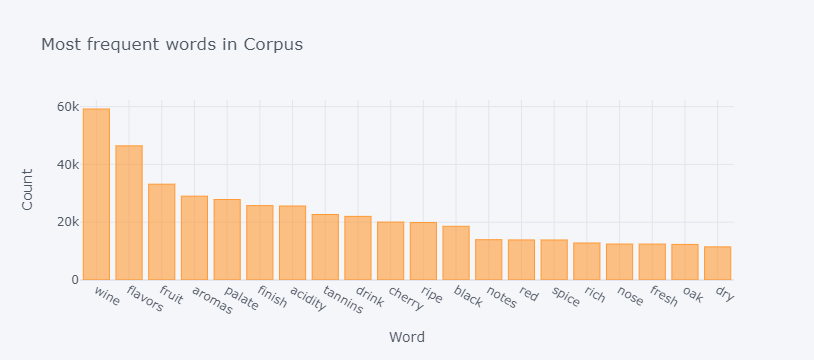

In [487]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

#### choosing vocabulary size with regards to number of records

In [488]:
new_size = words_df[words_df.wordCount >= 5].shape[0]
tr_size = words_df.shape[0]
tr_rec = train_data.shape[0]
print("Number of unique words in training dataset: {}".format(tr_size))
print("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(new_size))
print(f'propotion of new vocabulary from all training unique words is {new_size/tr_size:.3f}')
print("Number of records in training dataset: {}".format(tr_rec))
print(f'features vs records in training dataset: {new_size/tr_rec:.3f}')

Number of unique words in training dataset: 27943
Using words with 5 or more appearnces will reduce the corpus size to: 10607
propotion of new vocabulary from all training unique words is 0.380
Number of records in training dataset: 95990
features vs records in training dataset: 0.111


In [489]:
new_size = words_df[words_df.wordCount >= 2].shape[0]
tr_size = words_df.shape[0]
tr_rec = train_data.shape[0]
print("Number of unique words in training dataset: {}".format(tr_size))
print("Using words with 2 or more appearnces will reduce the corpus size to: {}".format(new_size))
print(f'propotion of new vocabulary from all training unique words is {new_size/tr_size:.3f}')
print("Number of records in training dataset: {}".format(tr_rec))
print(f'features vs records in training dataset: {new_size/tr_rec:.3f}')

Number of unique words in training dataset: 27943
Using words with 2 or more appearnces will reduce the corpus size to: 17601
propotion of new vocabulary from all training unique words is 0.630
Number of records in training dataset: 95990
features vs records in training dataset: 0.183


In [490]:
# we can see that ~40% of words appear once

#### BoW - Sparse Matrix representation

In [491]:
#defining the vocabulary:
#from train data only and appeared n_appear or above
#choosing 5 - as smaller may lead to overfit
n_appear = 5
vocab = set(words_df[words_df.wordCount >= n_appear].word) #set of all the words in vocab that appear n_appear or more

In [492]:
len(vocab)

10607

In [493]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [494]:
# sparse matrixes from train and test df
count_vect = CountVectorizer(vocabulary = vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_data.description_lowercase)
test_bow_counts = count_vect.fit_transform(test_data.description_lowercase)
assert(train_bow_counts.shape[0] + test_bow_counts.shape[0]  == wines.shape[0])
print('train:', train_bow_counts.shape[0], ' + test:',test_bow_counts.shape[0], ' = ', wines.shape[0])

train: 95990  + test: 23998  =  119988


In [495]:
#sparse matrix for train - defines which word_num appeared in a record - print a record:
print(train_bow_counts[1])

  (0, 79)	1
  (0, 264)	1
  (0, 424)	1
  (0, 433)	1
  (0, 950)	1
  (0, 960)	1
  (0, 1650)	1
  (0, 2932)	1
  (0, 3598)	1
  (0, 3631)	1
  (0, 3878)	1
  (0, 3925)	1
  (0, 3926)	1
  (0, 4993)	1
  (0, 7524)	1
  (0, 7805)	1
  (0, 8606)	1
  (0, 8963)	1
  (0, 9053)	1
  (0, 9362)	1
  (0, 10443)	1


In [496]:
print(train_data.iloc[1].desc_tokens)
#reverse dictionary rev_dict[word_num] ->word - print some examples:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[78])
print(rev_dict[260])
print(rev_dict[9040])
print(rev_dict[9348])
print(rev_dict[10426])

['this', 'is', 'ripe', 'and', 'fruity', 'a', 'wine', 'that', 'is', 'smooth', 'while', 'still', 'structured', 'firm', 'tannins', 'are', 'filled', 'out', 'with', 'juicy', 'red', 'berry', 'fruits', 'and', 'freshened', 'with', 'acidity', 'it', 'already', 'drinkable', 'although', 'it', 'will', 'certainly', 'be', 'better', 'from', '2016']
2015
achingly
stripped
tangent
willamette


### Linear Regression on BoW

#### finding optimized alpha

In [497]:
from sklearn.linear_model import LinearRegression, Ridge
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import plotly_express as px

In [498]:
%%capture
#search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
search_grid = np.logspace(-2, 2, num=10, endpoint=True, base=10.0)
auc_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_bow_counts, y = train_data.points, cv = 10, scoring = 'r2').mean()
    auc_by_alpha.append((alpha, avg_score))
    
#sources: https://scikit-learn.org/stable/modules/model_evaluation.html, 
#         https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
#         https://statisticsbyjim.com/regression/interpret-r-squared-regression/


In [499]:
#auc_by_alpha #### need to fix -> turn into dataframe?
cv_results = pd.DataFrame(auc_by_alpha, columns =['alpha', 'R2'])

max R^2 achieved =
 alpha    12.915497
R2        0.682643
Name: 7, dtype: float64


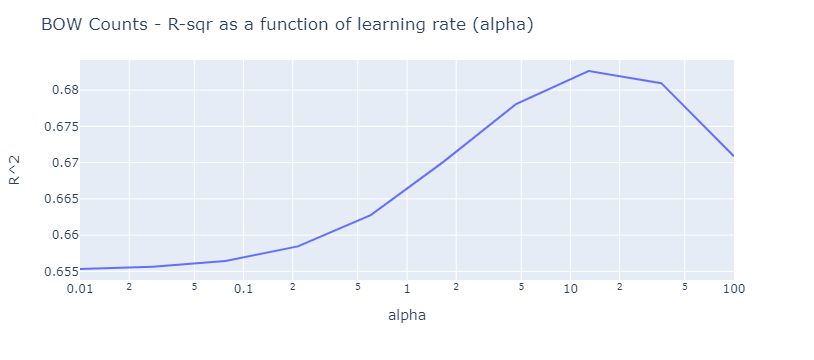

In [500]:
print("max R^2 achieved =\n", cv_results.iloc[cv_results.R2.idxmax()])
fig = px.line(cv_results, x='alpha', y='R2', log_x= True)
fig.update_layout(title_text= 'BOW Counts - R-sqr as a function of learning rate (alpha)')#, yaxis_range=[0, 1.0])
fig.update_yaxes(title_text= 'R^2', secondary_y=False)
fig.show()

In [501]:
print(cv_results.iloc[cv_results.R2.idxmax()])

alpha    12.915497
R2        0.682643
Name: 7, dtype: float64


#### running the linear regression on BoW with optimzed alpha

In [502]:
#run fit using train bow sparse matrix
opt_alpha = cv_results.iloc[cv_results.R2.idxmax()].alpha
# increase precision tol=1e-4
bow_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
bow_lreg.fit(train_bow_counts, y = train_data.points)

Ridge(alpha=12.915496650148826, tol=0.0001)

In [503]:
#use model to predict using test bow sparse matrix
bow_lreg_test = test_data.copy()
bow_lreg_test['bow_lin_reg'] = bow_lreg.predict(test_bow_counts)
#bow_lreg_test.sample(1)

In [504]:
calc_prediction_quality(bow_lreg_test, 'bow_lin_reg','points')

MSE    3.019525
MAE    1.371023
R2     0.683294
dtype: float64

### try ridgeCV

In [505]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error

In [506]:
#use ridge with CV built in; cv=10 fold; try alphas in the list
#source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

Ridge_clf = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0, 1000.0), cv=10)

In [507]:
#fit the model on train data
Ridge_clf.fit(train_bow_counts, y = train_data.points)

RidgeCV(alphas=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), cv=10)

In [508]:
#predict on test data
test_data['ridge_NLP'] = Ridge_clf.predict(test_bow_counts)

In [509]:
calc_prediction_quality(test_data, 'ridge_NLP','points')

MSE    3.025399
MAE    1.371738
R2     0.682678
dtype: float64

### bow prediction data - logging and comparing

In [97]:
#calculate model results
bow_lreg_stats = calc_prediction_quality(bow_lreg_test, 'bow_lin_reg','points')
all_compared = all_compared.append(bow_lreg_stats.to_frame(name='bow_linear_reg').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294


In [ ]:
#cleaning the data before tokenizing (my own function), vocab from training only,
# apperance of words >= 5, linear regression (Ridge, alpha=12.9 and RidgeCV)

#comparing different vocabularies:
# for appearance >= 5; not using clean_text (default tokenizer 'minus' stopwords)
# MSE    3.087962
# MAE    1.387830
# R2     0.676116

# using clean_text data (appearance >= 5)
# MSE    2.996614
# MAE    1.364713
# R2     0.685697

#using clean_text data appearnace >= 2
# MSE    2.981654
# MAE    1.361290
# R2     0.687266

# conclusions - very minor differences, but best achieved with using "clean" data appearnace >= 2

In [98]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [99]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using bow_linear_reg  =  3.020
min MAE using bow_linear_reg  =  1.371
max R2 using bow_linear_reg  =  0.683


## *Classical NLP - Text and Other Features

### combine BoW sparse matrix with encoded df

In [572]:
### resplitting encoded to train and test
train_enc = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:,0:8]
test_enc = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:,0:8]
assert(train_enc.shape[0] + test_enc.shape[0]  == encoded_features.shape[0])

In [573]:
train_enc.sample(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
65259,18,91,738,6,18,691,9363,11.0


In [574]:
### combining sparse encoded features with bow
from scipy.sparse import coo_matrix, hstack

train_features_sparse = coo_matrix(train_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
train_united_features = hstack((train_bow_counts, train_features_sparse)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
test_features_sparse = coo_matrix(test_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
test_united_features = hstack((test_bow_counts, test_features_sparse)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

train: (95990, 17687)  + test: (23998, 17687)  =  (119988, 9)


In [575]:
### trying to re-order tables - features first
### combining sparse encoded features with bow
from scipy.sparse import coo_matrix, hstack

train_features_sparse = coo_matrix(train_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
train_united_features = hstack((train_features_sparse, train_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
test_features_sparse = coo_matrix(test_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
test_united_features = hstack((test_features_sparse, test_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

train: (95990, 17687)  + test: (23998, 17687)  =  (119988, 9)


In [576]:
#### Ido tested to see why we get lower results w/united features
# ### combining sparse encoded features with bow 
# adding zeros or random as united -> seeing same issue

# train_features_sparse = coo_matrix(np.random.randn(train_enc.shape[0], train_enc.shape[1])) #constract sparse matrix from encoded df (next step to concat with BoW)
# train_united_features = hstack((train_bow_counts, train_features_sparse)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
# test_features_sparse = coo_matrix(np.random.randn(test_enc.shape[0], train_enc.shape[1])) #constract sparse matrix from encoded df (next step to concat with BoW)
# test_united_features = hstack((test_bow_counts, test_features_sparse)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
# assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
# print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

### Linear Regression on bow + features (unified)

In [582]:
#run fit using train bow sparse matrix
#using opt_alpha from above
united_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
united_lreg.fit(train_united_features, y = train_data.points)

Ridge(alpha=12.915496650148826, tol=0.0001)

In [584]:
#use model to predict using test bow sparse matrix
united_lreg_test = test_data.copy()
united_lreg_test['united_lin_reg'] = united_lreg.predict(test_united_features)
#united_lreg_test.sample(1)

In [585]:
calc_prediction_quality(united_lreg_test, 'united_lin_reg','points')

MSE    2.808586
MAE    1.319614
R2     0.705419
dtype: float64

### try RidgeCV

In [580]:
united_lreg = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0, 1000.0), cv=10)
united_lreg.fit(train_united_features, y = train_data.points)

RidgeCV(alphas=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), cv=10)

In [581]:
test_data['united_lin_reg'] = united_lreg.predict(test_united_features)
calc_prediction_quality(test_data, 'united_lin_reg','points')

MSE    3.344305
MAE    1.443693
R2     0.649229
dtype: float64

In [109]:
#calculate best model results
united_lreg_stats = calc_prediction_quality(united_lreg_test, 'united_lin_reg','points')
all_compared = all_compared.append(united_lreg_stats.to_frame(name='united_bow_enc_l_reg').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


#### conclusions

In [ ]:
#cleaning the data before tokenizing (my own function), vocab from training only,
# apperance of words >= 5, linear regression (Ridge, alpha=12.9, tol=1e-4)
# Ridge - initially showed lesser results than BoW only - solved using: tol=1e-4 
# concat "other" features with bow
#
#comparing unified trials:
#scaled (using StandardScaler)
# MSE    2.793977
# MAE    1.316041
# R2     0.706951
#normalized (using MinMaxScaler)
# MSE    2.860507
# MAE    1.333402
# R2     0.699973
#raw (using "as-is")
# MSE    2.808586
# MAE    1.319614
# R2     0.705419
#
#conclusions - very minor differences in this example (scaled is a bit better)
#
# scaling (vs normalizing) 
# sources:
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
# https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data
# https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832
#
#Ridge - initially showed lesser results than BoW only - solved using:
# tol=1e-4
# united_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
# tol is the tolerance for the stopping criteria. This tells scikit to stop searching for a minimum 
# (or maximum) once some tolerance is achieved, i.e. once you're close enough
# sources:
# https://stats.stackexchange.com/questions/255375/what-exactly-is-tol-tolerance-used-as-stopping-criteria-in-sklearn-models

In [110]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

## Neural Networks - No Text

In [111]:
### resplitting encoded to train and test
train_enc = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:,0:8]
test_enc = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:,0:8]
assert(train_enc.shape[0] + test_enc.shape[0]  == encoded_features.shape[0])

In [112]:
train_y = encoded_features[encoded_features.index.isin(train_data.index)].points
test_y = encoded_features[encoded_features.index.isin(test_data.index)].points
assert(train_y.shape[0] + test_y.shape[0]  == encoded_features.shape[0])

In [113]:
test_enc.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
8,17,308,738,6,1,209,8415,12.0


In [114]:
# train_data = noisy_xor_df.sample(frac=0.8)
# test_data = noisy_xor_df[~noisy_xor_df.index.isin(train_data.index)]
# assert(len(test_data) + len(train_data) == len(noisy_xor_df))

In [115]:
#install tensorflow
# import sys
# !{sys.executable} -m pip install tensorflow

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject



In [117]:
#create early stopping callback
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    restore_best_weights=True
)

In [118]:
model = Sequential()
model.add(Dense(256, input_dim=8))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)

In [119]:
#more complex models - did not achieve better results
# model = Sequential()
# model.add(Dense(256, input_dim=8, activation='tanh'))
# model.add(Dense(128, activation='tanh'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(1))

# optimizer = Adam(learning_rate=0.001)
# model.compile(loss='mse', optimizer=optimizer)

In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


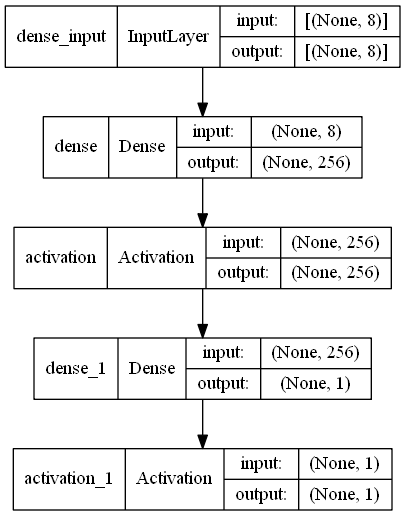

In [121]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [122]:
model.fit(train_enc, train_y, validation_data=(test_enc, test_y),
          batch_size=50, epochs=100, verbose=True, callbacks=[early_stopping_monitor])

Epoch 1/100
1920/1920 [==============================] - 3s 1ms/step - loss: 536.6515 - val_loss: 9.6225
Epoch 2/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.6237 - val_loss: 9.5804
Epoch 3/100
1920/1920 [==============================] - 2s 1ms/step - loss: 9.5864 - val_loss: 9.5489
Epoch 4/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.5887 - val_loss: 9.5266
Epoch 5/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.5926 - val_loss: 9.5250s - loss: 9
Epoch 6/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.5741 - val_loss: 9.5826
Epoch 7/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.4756 - val_loss: 9.4321
Epoch 8/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.2745 - val_loss: 8.4967
Epoch 9/100
1920/1920 [==============================] - 3s 1ms/step - loss: 8.7948 - val_loss: 8.1876
Epoch 10/100
1920/1920 [==============================] - 3s

In [123]:
test_predict = pd.DataFrame()
test_predict['points'] = test_y
test_predict['neuron network'] = model.predict(test_enc)

In [124]:
#check stats and add to comparison df
neuron_nwk_stats = calc_prediction_quality(test_predict, 'neuron network','points')
all_compared = all_compared.append(neuron_nwk_stats.to_frame(name='neuron network no txt').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


In [125]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

## Neural Networks - No Text - Scaled

#### train and test data

In [126]:
### resplitting encoded to train and test
train_enc = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:,0:8]
test_enc = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:,0:8]
assert(train_enc.shape[0] + test_enc.shape[0]  == encoded_features.shape[0])

In [127]:
train_y = encoded_features[encoded_features.index.isin(train_data.index)].points
test_y = encoded_features[encoded_features.index.isin(test_data.index)].points
assert(train_y.shape[0] + test_y.shape[0]  == encoded_features.shape[0])

#### scaling

In [128]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_enc.values)
scaled_train_df = pd.DataFrame(scaled_train, index=train_enc.index, columns=train_enc.columns)
scaled_test = scaler.transform(test_enc.values)
scaled_test_df = pd.DataFrame(scaled_test, index=test_enc.index, columns=test_enc.columns)

# scaling 
# sources:
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
# https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data
# https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832

In [558]:
encoded_features.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87


In [ ]:
# from matplotlib import pyplot as plt
# import matplotlib.mlab as mlab

# array = encoded_features.province.to_numpy()

# n, bins, patches = plt.hist(array, 50, normed=1)
# mu = np.mean(array)
# sigma = np.std(array)
# plt.plot(bins, mlab.normpdf(bins, mu, sigma))

In [129]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping

In [130]:
model = Sequential()
model.add(Dense(32, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

#optimizer = SGD(learning_rate=0.1)
optimizer = Adam(learning_rate=0.001) #0.3
#optimizer = Adam() #0.3
#optimizer = Adadelta()
#optimizer = Nadam()
model.compile(loss='mse', optimizer=optimizer)

In [131]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                288       
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [132]:
#define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

In [133]:
model.fit(scaled_train_df, train_y, validation_data=(scaled_test_df, test_y),
          batch_size=30, epochs=100, verbose=True, callbacks=[early_stopping])

Epoch 1/100
3200/3200 [==============================] - 5s 2ms/step - loss: 551.8961 - val_loss: 15.4028
Epoch 2/100
3200/3200 [==============================] - 5s 2ms/step - loss: 10.1812 - val_loss: 7.5662
Epoch 3/100
3200/3200 [==============================] - 5s 2ms/step - loss: 7.8629 - val_loss: 7.0113
Epoch 4/100
3200/3200 [==============================] - 5s 2ms/step - loss: 7.2808 - val_loss: 6.8013
Epoch 5/100
3200/3200 [==============================] - 5s 2ms/step - loss: 6.8337 - val_loss: 6.6112
Epoch 6/100
3200/3200 [==============================] - 5s 2ms/step - loss: 6.6551 - val_loss: 6.4216
Epoch 7/100
3200/3200 [==============================] - 6s 2ms/step - loss: 6.5671 - val_loss: 6.4426
Epoch 8/100
3200/3200 [==============================] - 6s 2ms/step - loss: 6.5111 - val_loss: 6.4428
Epoch 9/100
3200/3200 [==============================] - 6s 2ms/step - loss: 6.4148 - val_loss: 6.3229
Epoch 10/100
3200/3200 [==============================] - 5s 2ms/step

In [134]:
test_predict = pd.DataFrame()
test_predict['points'] = test_y
test_predict['neuron network'] = model.predict(scaled_test_df)

In [135]:
#check stats and add to comparison df
neuron_nwk_stats = calc_prediction_quality(test_predict, 'neuron network','points')
all_compared = all_compared.append(neuron_nwk_stats.to_frame(name='neuron network scaled').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


In [136]:
# best for now: Adam lr=0.001 (default), batch=30, scaled data, relu, dense->16,8,1 - MSE 5.6
# Adadelta -> MSE 84.5 (maybe try more epochs)
# Nadam -> MSE 7.65 
# Adam dense->128,64,1 - MSE 5.56 (small improvement to 16, 8)
# Adam dense->32,16,1 - MSE 5.86

In [137]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [138]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using united_bow_enc_l_reg  =  2.853
min MAE using united_bow_enc_l_reg  =  1.331
max R2 using united_bow_enc_l_reg  =  0.701


## Fully connected network on the text only (clean_text)

#### Tokenization

In [139]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [140]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [143]:
#clean description (as TextVectorization does not remove stopwords)
from src.models import clean_text
wines['clean_desc'] = wines.description.apply(lambda desc: clean_text(desc, stopwords))
wines.clean_desc.sample(1)

In [427]:
substr = 'ultraripe'
#wines[wines.description.apply(lambda desc: True if substr in desc else False)]
wines.description.iloc[1386]

'The high alcohol is a good indication of the ultraripe fruit flavors here. Raisins and cooked cherries dominate, set against a background of tart cherry-pie acids. The concentration is impressive, as is the purity of the fruit flavors.'

In [148]:
############ resplitting wines to train and test
train_data = wines[wines.index.isin(train_data.index)]
test_data = wines[wines.index.isin(test_data.index)]
assert(train_data.shape[0] + test_data.shape[0]  == wines.shape[0])

In [404]:
vocab_size = 32000
sequence_length = 72 #60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [405]:
vectorize_layer.adapt(train_data['clean_desc']) #using cleaned description

In [415]:
sample_description = train_data['clean_desc'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

high toned aromas blackberry aniseed macerated cranberry motor oil flower lead rich full bodied cranberry blackberry flavors bring sense hedonism


<tf.Tensor: shape=(72,), dtype=int64, numpy=
array([ 146,  575,    5,   31, 3385, 4068,  189, 8739, 1035,  202,  114,
         18,   23,   40,  189,   31,    3,  588,  351, 4454,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)>

In [416]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

146 --->  high
575 --->  toned
5 --->  aromas
31 --->  blackberry
3385 --->  aniseed
4068 --->  macerated
189 --->  cranberry
8739 --->  motor
1035 --->  oil
202 --->  flower
114 --->  lead
18 --->  rich
23 --->  full
40 --->  bodied
189 --->  cranberry
31 --->  blackberry
3 --->  flavors
588 --->  bring
351 --->  sense
4454 --->  hedonism


#### Modeling

In [ ]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 30
mloss = 'mse'
n_lr = 3e-4
active_f = 'tanh'

In [157]:
#create model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(nn, activation=active_f, name='hidden_layer'),
    Dropout(ndropout),
    Dense(1, name = 'output_layer')
])

In [158]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 16)            512000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 820)               13940     
                                                                 
 dropout_1 (Dropout)         (None, 820)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

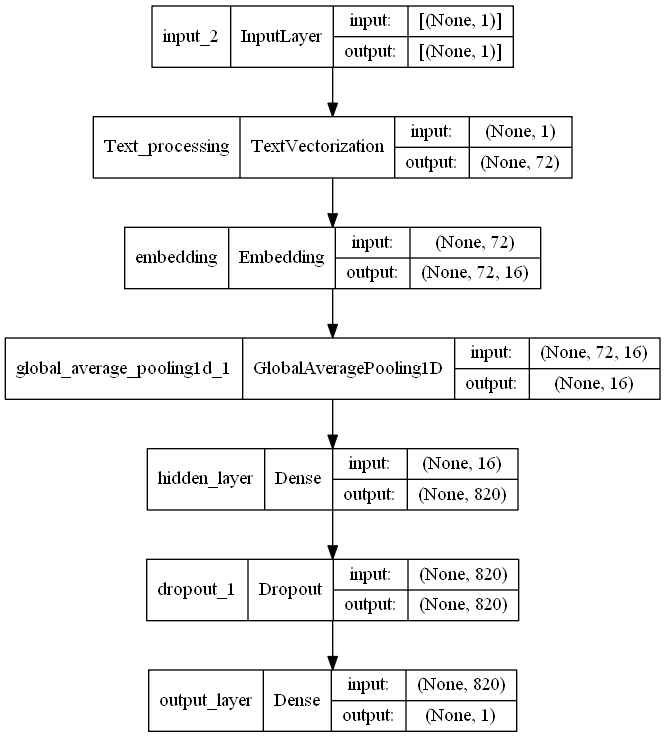

In [159]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [160]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [161]:
%%time
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
3000/3000 [==============================] - 29s 10ms/step - loss: 571.6100 - val_loss: 9.7277
Epoch 2/30
3000/3000 [==============================] - 28s 9ms/step - loss: 8.5773 - val_loss: 4.7161
Epoch 3/30
3000/3000 [==============================] - 25s 8ms/step - loss: 6.3791 - val_loss: 3.8231
Epoch 4/30
3000/3000 [==============================] - 28s 9ms/step - loss: 5.7527 - val_loss: 3.6289
Epoch 5/30
3000/3000 [==============================] - 24s 8ms/step - loss: 5.4068 - val_loss: 3.3713
Epoch 6/30
3000/3000 [==============================] - 26s 9ms/step - loss: 5.2741 - val_loss: 3.2605
Epoch 7/30
3000/3000 [==============================] - 25s 8ms/step - loss: 5.1645 - val_loss: 3.4847
Epoch 8/30
3000/3000 [==============================] - 27s 9ms/step - loss: 5.0879 - val_loss: 3.3204
Epoch 9/30
3000/3000 [==============================] - 28s 9ms/step - loss: 5.0386 - val_loss: 3.1925
Epoch 10/30
3000/3000 [==============================] - 29s 10ms/step

#### Simple NN Prediction & Evaluation

In [162]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [ ]:
from src.models import plot_model_param
plot_model_param(history, "loss")

In [164]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
all_compared = all_compared.append(stats.to_frame(name='fully connec text only').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


In [165]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [166]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using united_bow_enc_l_reg  =  2.853
min MAE using united_bow_enc_l_reg  =  1.331
max R2 using united_bow_enc_l_reg  =  0.701


## Fully Connected (Text Only) - words Concatinated

In [167]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [168]:
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 30
mloss = 'mse'
n_lr = 3e-4
active_f = 'tanh'

In [169]:
#create model
#using reshape to concat the vectors - should add also more info on order of words
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(nn, activation=active_f, name='hidden_layer'),
    Dropout(ndropout),
    Dense(1, name = 'output_layer')
])

In [171]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

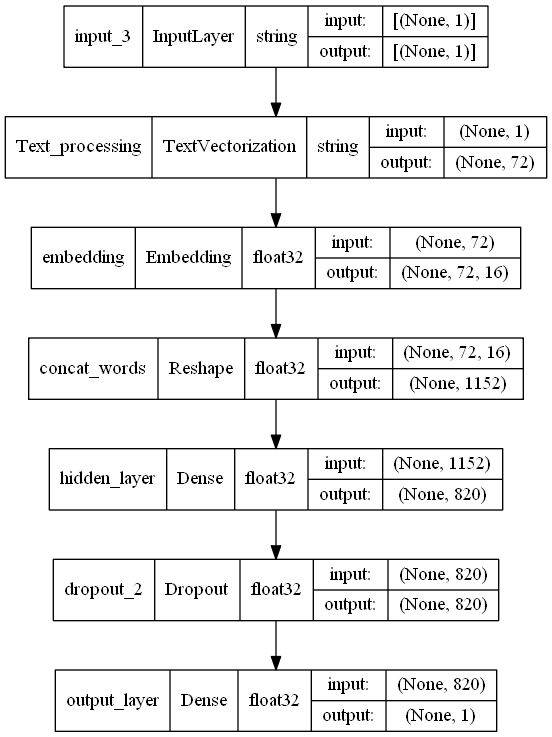

In [172]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [174]:
%%time
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
3000/3000 [==============================] - 56s 19ms/step - loss: 5.2576 - mean_squared_error: 5.2576 - mean_absolute_error: 1.8232 - val_loss: 3.0622 - val_mean_squared_error: 3.0622 - val_mean_absolute_error: 1.3782
Epoch 2/30
3000/3000 [==============================] - 55s 18ms/step - loss: 5.0316 - mean_squared_error: 5.0316 - mean_absolute_error: 1.7821 - val_loss: 3.1881 - val_mean_squared_error: 3.1881 - val_mean_absolute_error: 1.4190
Epoch 3/30
3000/3000 [==============================] - 55s 18ms/step - loss: 4.9231 - mean_squared_error: 4.9231 - mean_absolute_error: 1.7658 - val_loss: 2.9224 - val_mean_squared_error: 2.9224 - val_mean_absolute_error: 1.3487
Epoch 4/30
3000/3000 [==============================] - 55s 18ms/step - loss: 4.7678 - mean_squared_error: 4.7678 - mean_absolute_error: 1.7362 - val_loss: 3.0936 - val_mean_squared_error: 3.0936 - val_mean_absolute_error: 1.3852
Epoch 5/30
3000/3000 [==============================] - 55s 18ms/step - loss: 4.

In [175]:
test_data['dnn_concat'] = model.predict(test_data[text_col])

In [176]:
calc_prediction_quality(test_data, 'dnn_concat', target_col)

MSE    2.922386
MAE    1.348727
R2     0.693483
dtype: float64

In [ ]:
from src.models import plot_model_param
plot_model_param(history, "loss")

In [177]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'dnn_concat', target_col)
all_compared = all_compared.append(stats.to_frame(name='fully connec text only concat').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


In [178]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [179]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using united_bow_enc_l_reg  =  2.853
min MAE using united_bow_enc_l_reg  =  1.331
max R2 using united_bow_enc_l_reg  =  0.701


## *External embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

#### Load pre-trained word embeddings

In [417]:
import os
import numpy as np

In [418]:
#downloaded "glove.6B.100d.txt" to /data folder from https://www.kaggle.com/datasets/anmolkumar/glove-embeddings
#filename = "glove.6B.100d.txt"
filename = "glove.42B.300d.txt"
#filename = "glove.840B.300d.txt" #corrupted?
mypth = os.getcwd()
path_to_glove_file = mypth + "\\data\\" + filename
path_to_glove_file

'C:\\Users\\oshepon\\Python-ML\\Python_ML-2022\\Python_ML-2022\\Final project\\data\\glove.42B.300d.txt'

#### dict mapping words (strings) to their NumPy vector representation:

In [419]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [420]:
# glove.6B.100d.txt:
# found 400000 word vectors
#
# "glove.42B.300d.txt":
#Found 1917494 word vectors.

#### prepare embedding matrix 

In [434]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

In [422]:
sample_description = train_data['clean_desc'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

fresh zesty lime notes mingle aromas ripe peach honeysuckle lean revitalizing dry riesling steely rather overtly fruity palate honed minerality accentuated streaks lemon lime acidity


<tf.Tensor: shape=(72,), dtype=int64, numpy=
array([  19,  227,   90,   16,  885,    5,   13,   52,  432,  271, 3232,
         20,  252,  461,  283, 2160,   48,    6, 4018,  179, 3669,  960,
         49,   90,    8,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)>

In [423]:
num_tokens = len(vocab) + 2
#embedding_dim = 100 #we chose glove.6B.100d.txt with 100D
embedding_dim = 300 #we chose glove.42B.300d.txt with 300D
hits = 0
misses = 0

# Prepare embedding matrix
missing_words = []
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missing_words.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 25158 words (2823 misses)


In [424]:
#Examples of words in wines review that are NOT in the external vocabulary
print(missing_words[0:20])

['', '[UNK]', 'mourv', 'ritif', 'woodspice', 'tlese', 'torront', 'scoury', 'ultraripe', 'teauneuf', 'unripeness', 'liquorous', 'blaufr', 'nkisch', 'overripeness', 'tropicality', 'smackingly', 'overoaked', 'gociant', 'salinic']


In [611]:
substr = 'woodspice'
#wines[wines.description.apply(lambda desc: True if substr in desc else False)]
wines.description.iloc[18]

'Desiccated blackberry, leather, charred wood and mint aromas carry the nose on this full-bodied, tannic, heavily oaked Tinto Fino. Flavors of clove and woodspice sit on top of blackberry fruit, then hickory and other forceful oak-based aromas rise up and dominate the finish.'

In [430]:
wines.clean_desc.iloc[18]

'desiccated blackberry leather charred wood mint aromas carry nose full bodied tannic heavily oaked tinto fino flavors clove woodspice sit top blackberry fruit hickory forceful oak based aromas rise dominate finish'

In [431]:
# we can see special wine-review Jargon : 
# 'overripeness', 'tropicality', 'smackingly', 'overoaked', 'gociant', 'salinic'
#'ultraripe', 'scoury', 'unripeness', 'woodspice'...  

In [432]:
#our vocab is 32000
#with "glove.6B.100D.txt"  -> Converted 19453 words (12547 misses) 
#     "glove.42B.300d.txt" -> Converted 21877 words (10123 misses)
#     "glove.42B.300d.txt" -> Converted 25158 words (2823 misses) - post "cleaning" description (my function)

#### Create Embedding Layer

In [433]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
#    trainable=True,
)
# trainable=False so as to keep the embeddings fixed; True - will continue learning (very slow - high dim!)

#### Building the model

In [441]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [444]:
#embedding_dim = 300 #defined earlier based on external file
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 30
mloss = 'mse'
n_lr = 3e-4
active_f = 'tanh'

In [445]:
#create model
#using reshape to concat the vectors - should add also more info on order of words
#replaced embedding layer with pre-build embedding built using Glove external embedding
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(nn, activation=active_f, name='hidden_layer'),
    Dropout(ndropout),
    Dense(1, name = 'output_layer')
])

In [446]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [447]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding_12 (Embedding)    (None, 72, 300)           8394900   
                                                                 
 concat_words (Reshape)      (None, 21600)             0         
                                                                 
 hidden_layer (Dense)        (None, 820)               17712820  
                                                                 
 dropout_15 (Dropout)        (None, 820)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 821       
                                                     

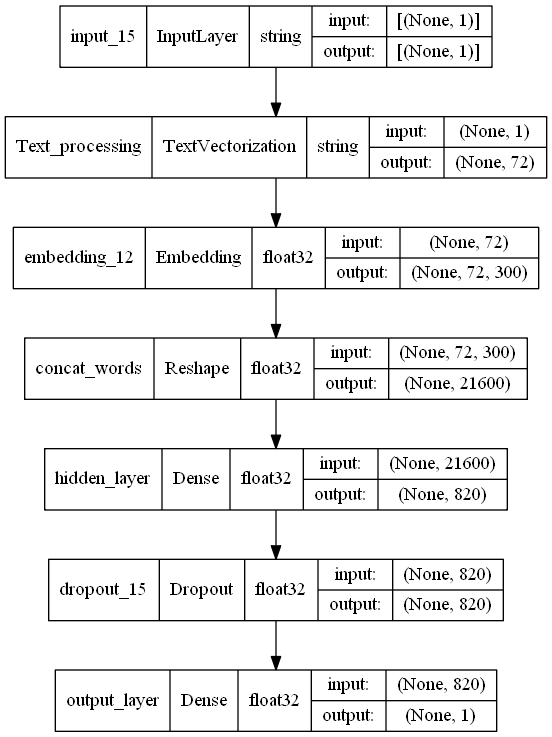

In [448]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [449]:
%%time
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
3000/3000 [==============================] - 428s 142ms/step - loss: 98.2748 - mean_squared_error: 98.2748 - mean_absolute_error: 4.8800 - val_loss: 4.5303 - val_mean_squared_error: 4.5303 - val_mean_absolute_error: 1.6816
Epoch 2/30
3000/3000 [==============================] - 450s 150ms/step - loss: 6.6281 - mean_squared_error: 6.6281 - mean_absolute_error: 2.0455 - val_loss: 3.8985 - val_mean_squared_error: 3.8985 - val_mean_absolute_error: 1.5638
Epoch 3/30
3000/3000 [==============================] - 402s 134ms/step - loss: 6.2271 - mean_squared_error: 6.2271 - mean_absolute_error: 1.9853 - val_loss: 3.9867 - val_mean_squared_error: 3.9867 - val_mean_absolute_error: 1.5792
Epoch 4/30
3000/3000 [==============================] - 399s 133ms/step - loss: 5.8982 - mean_squared_error: 5.8982 - mean_absolute_error: 1.9316 - val_loss: 3.7642 - val_mean_squared_error: 3.7642 - val_mean_absolute_error: 1.5342
Epoch 5/30
3000/3000 [==============================] - 382s 127ms/ste

In [450]:
test_data['ext_embedding'] = model.predict(test_data[text_col])

In [451]:
calc_prediction_quality(test_data, 'ext_embedding', target_col)

MSE    3.764231
MAE    1.534216
R2     0.605185
dtype: float64

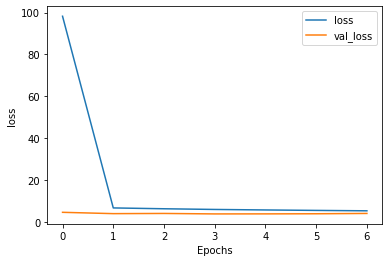

In [452]:
plot_model_param(history, "loss")

In [207]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'ext_embedding', target_col)
all_compared = all_compared.append(stats.to_frame(name='ext_embedding text only concat').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


#### Conclusions

In [ ]:
# initally: used glove.6B.100D.txt as external embedding (100 dim) and default tokenizer
# Converted 19453 words (12547 misses); MSE ~9
# to improve: used larger Glove 42B glove.42B.300d.txt (300 dim) but 
# Converted 21877 words (10123 misses); MSE ~8
# tried trainable=True (in embedding layer creation) - so embedding is not fixed and continues to train. 
# very minor improvement; model is really-really slow (very high dim; 300)
# Eventually: used clean_text to better clean the data for tokenizer + file 42B glove.42B.300d.txt:
# Converted 25158 words (2823 misses); MSE 3.75
# to compare to "our" embedding:
# model very similar to fully-connected concatinated with our "own" embedding -> MSE 2.9
#
# from missing_word_list: we can see special wine-review Jargon : 'ultraripe', 'scoury', 'unripeness', 
# 'woodspice'...  My assumption is that those missing words cause the model degrade vs internal
# trained embedding on the wine review Jargon. In order to improve - prob need to continue text pre-processing
# and cleaning to reduce misses. On top - model is much slower due to high dim of the embedding (300)
# for this specific dataset - external embedding is not a good solution
#
#
# notes on the model:
# built embedding_layer -> based on embedding_matrix from glove file:
# external embedding layer: embeddings_initializer=keras.initializers.Constant(embedding_matrix)
# learning rate = 3e-4; neurons = 820 in dense, dropout = 0.2; activation function = 'tanh'
# sequence_length = 72 (capture >99% review at full)

In [208]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [209]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using united_bow_enc_l_reg  =  2.853
min MAE using united_bow_enc_l_reg  =  1.331
max R2 using united_bow_enc_l_reg  =  0.701


In [210]:
#history results:
#with glove.6B.100D.txt -> 
# MSE    9.313706
# MAE    2.444108
# R2     0.032555
# dtype: float64
#Ido's param: loss=mae, early stop=va_mean_square_error, patience=2; batch_size=128, 
#  dense 164 neurons, dropout=0.7, trainable=false
#  trainable=True -> very little improvement

# "glove.42B.300d.txt" ->
# MSE    8.659561
# MAE    2.361763
# R2     0.100503
# dtype: float64

## *LSTM description feature only

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [278]:
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam

In [279]:
#optimized params chosen
embedding_dim = 16 #use 8?
nn = 32
ndropout = 0.2 
active_f = 'tanh'
nbatch  = 64 #32
mloss = 'mse'
n_lr = 3e-3 #3e-4
#
nepochs = 30

#### create model

In [280]:
#create model with LSTM with Bidirectional wrapper
model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        Embedding(vocab_size+1, embedding_dim, input_length= sequence_length, name="embedding", mask_zero=True),
        Bidirectional(LSTM(64)),
        Dense(64, activation='relu', name='hidden_layer'),
        Dense(1, name = 'output_layer')
    ])

In [281]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [282]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 16)            512016    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              41472     
 nal)                                                            
                                                                 
 hidden_layer (Dense)        (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 561,809
Trainable params: 561,809
Non-t

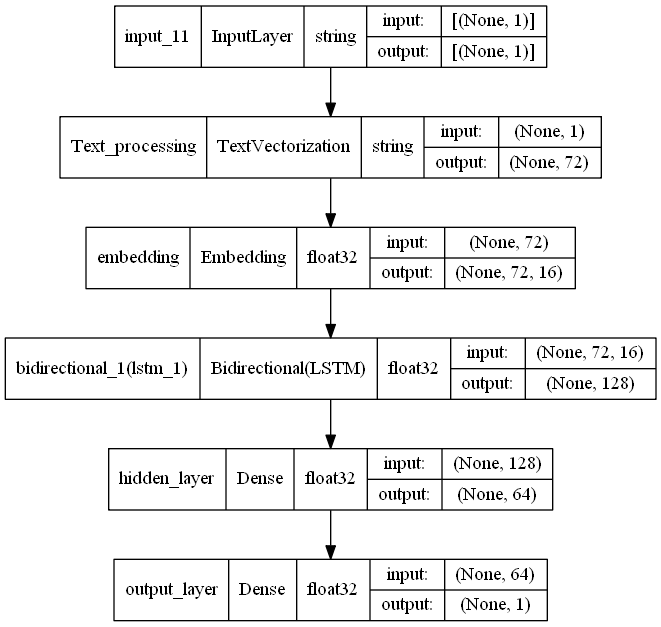

In [283]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [284]:
%%time
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
1500/1500 [==============================] - 347s 227ms/step - loss: 98.9134 - mean_squared_error: 98.9134 - mean_absolute_error: 3.8467 - val_loss: 9.7088 - val_mean_squared_error: 9.7088 - val_mean_absolute_error: 2.5026
Epoch 2/30
1500/1500 [==============================] - 348s 232ms/step - loss: 7.2626 - mean_squared_error: 7.2626 - mean_absolute_error: 2.1169 - val_loss: 5.5272 - val_mean_squared_error: 5.5272 - val_mean_absolute_error: 1.8584
Epoch 3/30
1500/1500 [==============================] - 344s 230ms/step - loss: 3.6028 - mean_squared_error: 3.6028 - mean_absolute_error: 1.4851 - val_loss: 3.2178 - val_mean_squared_error: 3.2178 - val_mean_absolute_error: 1.4014
Epoch 4/30
1500/1500 [==============================] - 345s 230ms/step - loss: 2.7543 - mean_squared_error: 2.7543 - mean_absolute_error: 1.3033 - val_loss: 3.0806 - val_mean_squared_error: 3.0806 - val_mean_absolute_error: 1.3770
Epoch 5/30
1500/1500 [==============================] - 352s 235ms/ste

In [285]:
test_data['LSTM'] = model.predict(test_data[text_col])

In [286]:
calc_prediction_quality(test_data, 'LSTM', target_col)

MSE    2.959647
MAE    1.340781
R2     0.689574
dtype: float64

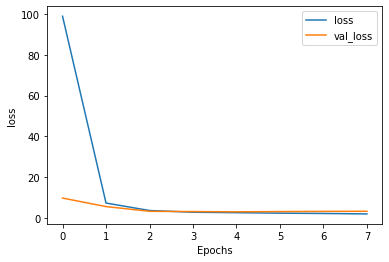

In [287]:
plot_model_param(history, "loss")

In [252]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'LSTM', target_col)
all_compared = all_compared.append(stats.to_frame(name='LSTM text only').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


#### conclusions

In [ ]:
# some notes on LSTM model:
# sequence length of 72 (words in a review); embedding dim of 16
# Used Bidirectional wrapper over LSTM and masking due to padding
# 64 memory units for LSTM + dense hidden layer with 64 neurons


# more details:
# Bidirectional - to make the input flow in both directions to preserve the future and the past information. 
# Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. 
# Unlike standard LSTM, the input flows in both directions, and it’s capable of utilizing information from both
# sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both 
# directions of the sequence.
# sources:
# https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm
# https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
#
#  mask_zero=True
# Padding is a special form of masking where the masked steps are at the start or the end of a sequence.
# Padding comes from the need to encode sequence data into contiguous batches: in order to make all 
# sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.
# Now that all samples have a uniform length, the model must be informed that some part of the data is
# actually padding and should be ignored. That mechanism is masking.
# You can now use this mask in-between a mask-generating layer (like Embedding) and a mask-consuming 
# layer (like LSTM), and it will pass the mask along so that it reaches the mask-consuming layer
# sources:
# https://towardsdatascience.com/how-does-masking-work-in-an-rnn-and-variants-and-why-537bf63c306d
# https://www.tensorflow.org/guide/keras/masking_and_padding
# vocab_size + 1 (here: 32000 + 1)
# if you enable masking, value 0 is treated differently, so you increment your n indices by one:
# [0, 1, 2, ..., n-1, n], thus you need:  input_dim = len(vocabulary_indices) + 1 or alternatively:
# input_dim = max(vocabulary_indices) + 2
# sources:
# https://stackoverflow.com/questions/43227938/keras-embedding-layer-masking-why-does-input-dim-need-to-be-vocabulary-2

In [253]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [254]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using united_bow_enc_l_reg  =  2.853
min MAE using united_bow_enc_l_reg  =  1.331
max R2 using united_bow_enc_l_reg  =  0.701


#### Save the Model

In [276]:
import os
model_dir = "LSTM_text_only"
mypth = os.getcwd()
path_to_LSTM_model = mypth + "\\models\\" + model_dir
#save model to dir
model.save(path_to_LSTM_model)
# del model
# # Recreate the exact same model purely from the file:
# model = keras.models.load_model(path_to_LSTM_model)

In [271]:
print(test_data[text_col].iloc[0])
model.predict([test_data[text_col].iloc[0]])

savory dried thyme notes accent sunnier flavors preserved peach brisk dry wine fruity fresh elegant sprightly footprint


array([[87.78938]], dtype=float32)

In [ ]:
#delete model
#del model

In [277]:
# Recreate the exact same model purely from the file:
model_bu = keras.models.load_model(path_to_LSTM_model)

ValueError: Exception encountered when calling layer "forward_lstm" (type LSTM).

The mask that was passed in was tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64)), which cannot be applied to RaggedTensor inputs. Please make sure that there is no mask injected by upstream layers.

Call arguments received:
  • inputs=tf.RaggedTensor(values=Tensor("Placeholder:0", shape=(None, 16), dtype=float32), row_splits=Tensor("Placeholder_1:0", shape=(None,), dtype=int64))
  • mask=tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64))
  • training=None
  • initial_state=None

In [273]:
model_bu.predict([test_data[text_col].iloc[0]])

NameError: name 'model' is not defined

#### history trials

In [255]:
#history results
# LSTM layer only with 32nn
# MSE    9.922737
# MAE    2.544019
# R2    -0.040756

#create model with LSTM
# model = tf.keras.Sequential([
#         tf.keras.Input(shape=(1,), dtype=tf.string),
#         vectorize_layer,
#         Embedding(vocab_size+1, embedding_dim, input_length= sequence_length, name="embedding", mask_zero=True),
#         LSTM(units=nn, activation=active_f, name='RNN_layer'),
#         Dropout(ndropout),
#         Dense(nn, activation=active_f, name='hidden_layer'),
#         Dropout(ndropout),
#         Dense(1, name = 'output_layer')
#     ])
#n_lr=3e-4, batch=32, active_f=tanh, nn=64
# MSE    3.296888
# MAE    1.433300
# R2     0.654203

# #optimized params chosen
# embedding_dim = 16 #use 8?
# nn = 64
# ndropout = 0.2 
# active_f = 'tanh'
# nbatch  = 32
# mloss = 'mse'
# n_lr = 3e-4
# #
# nepochs = 30
#create model with LSTM
# model = tf.keras.Sequential([
#         tf.keras.Input(shape=(1,), dtype=tf.string),
#         vectorize_layer,
#         Embedding(vocab_size, embedding_dim, input_length= sequence_length, name="embedding"),
#         LSTM(units=nn, activation=active_f, name='RNN_layer'),
#         Dropout(ndropout),
#         Dense(nn, activation=active_f, name='hidden_layer'),
#         Dropout(ndropout),
#         Dense(1, name = 'output_layer')
#     ])
#results:
# MSE    9.623056
# MAE    2.518822
# R2    -0.009324

## *Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

In [453]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [454]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 10 #6 #30
mloss = 'mse'
n_lr = 5e-4 #1e-3
active_f = 'tanh'

# keep only trained params
scaled_test_df = scaled_test_df.iloc[:,0:8]


In [455]:
#params:
#vectorize_layer TextVectorization
#vocab_size = 32000
#sequence_length = 72 #60

#using the kerashape=unctional API to build a model with 2 inputs
#descrption text embedding --- 1st input ---
desc_input = keras.Input(shape=(1,), dtype="string", name="text")
token_input = vectorize_layer(desc_input)
desc_features = layers.Embedding(vocab_size, 16)(token_input)
#desc_features = layers.LSTM(128, name='text_LSTM')(desc_features)
desc_features = Bidirectional(LSTM(64))(desc_features)
desc_features = Dense(64, activation='relu', name='LSTM_hidden')(desc_features)
#other data --- 2nd input ----
other_input = keras.Input(shape=(8,), name="other")
other_features = layers.Dense(32, name="other_hidden")(other_input)
#concatenate --- concat both inputs ---
x = layers.concatenate([desc_features, other_features])
#hidden layer
hidden = layers.Dense(96, name="unified_hidden")(x)
#output
points_pred = layers.Dense(1, name="points_prediction")(hidden)
# Instantiate an end-to-end model from both inputs -> 1 output
model = keras.Model(
    inputs=[desc_input, other_input],
    outputs=[points_pred],
)


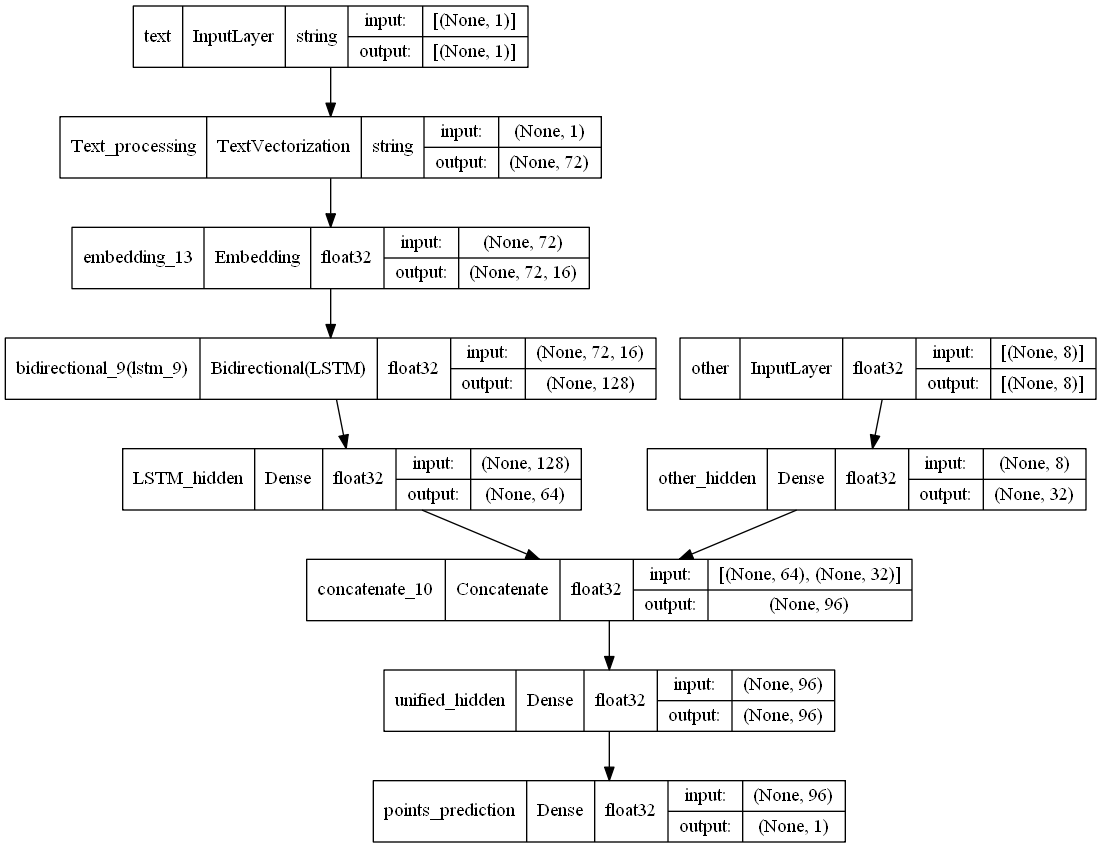

In [456]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [457]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Text_processing (TextVectoriza  (None, 72)          0           ['text[0][0]']                   
 tion)                                                                                            
                                                                                                  
 embedding_13 (Embedding)       (None, 72, 16)       512000      ['Text_processing[4][0]']        
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 128)         41472       ['embedding_13[0][0]']     

In [458]:
#compile the model
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [459]:
%%time
#for text data
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    min_delta=0,
    patience=2, #3
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    x=[train_data[text_col], scaled_train_df],
    y=train_y,
    epochs=nepochs,
    batch_size=nbatch,
    verbose=True, 
    callbacks=[early_stopping],
    validation_data=[[test_data[text_col], scaled_test_df], test_y]
)
# train(x) and validation_data inputs are list of input1, input2
#see
#https://stackoverflow.com/questions/46125729/cant-pass-validation-data-to-a-model-with-several-inputs-in-keras

Epoch 1/10
3000/3000 [==============================] - 414s 136ms/step - loss: 108.1145 - mean_squared_error: 108.1145 - mean_absolute_error: 3.4998 - val_loss: 6.9409 - val_mean_squared_error: 6.9409 - val_mean_absolute_error: 2.1127
Epoch 2/10
3000/3000 [==============================] - 434s 145ms/step - loss: 3.9436 - mean_squared_error: 3.9436 - mean_absolute_error: 1.5363 - val_loss: 4.8974 - val_mean_squared_error: 4.8974 - val_mean_absolute_error: 1.8058
Epoch 3/10
3000/3000 [==============================] - 413s 138ms/step - loss: 2.8109 - mean_squared_error: 2.8109 - mean_absolute_error: 1.3120 - val_loss: 2.9037 - val_mean_squared_error: 2.9037 - val_mean_absolute_error: 1.3495
Epoch 4/10
3000/3000 [==============================] - 406s 135ms/step - loss: 2.6147 - mean_squared_error: 2.6147 - mean_absolute_error: 1.2632 - val_loss: 2.7115 - val_mean_squared_error: 2.7115 - val_mean_absolute_error: 1.2946
Epoch 5/10
3000/3000 [==============================] - 417s 139ms/s

In [460]:
scaled_test_df = scaled_test_df.iloc[:,0:8]
#scaled_test_df.head(1)

In [461]:
#preds_prob = model.predict([X_test_feature1, X_test_feature2])
scaled_test_df['unified_keras_api'] = model.predict([test_data[text_col], scaled_test_df])

In [462]:
scaled_test_df['points'] = test_y

In [463]:
calc_prediction_quality(scaled_test_df, 'unified_keras_api', target_col)

MSE    2.711491
MAE    1.294558
R2     0.715603
dtype: float64

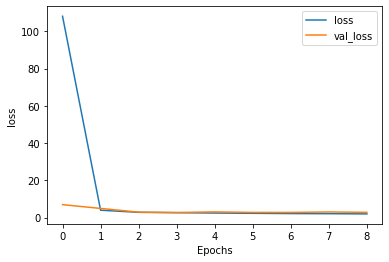

In [464]:
plot_model_param(history, "loss")

In [467]:
#check stats and add to comparison df
stats = calc_prediction_quality(scaled_test_df, 'unified_keras_api', target_col)
all_compared = all_compared.append(stats.to_frame(name='unified_keras_api').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


#### conclusions

In [ ]:
# General conclusions:
#1. best model -> all features using keras functional API (used scaled data for "other" features)
#2. second best model -> all features (bow and scaled "other" features; using Ridge linear regression)
#3. without text (NLP): MSE ~6 ; with text: MSE ~3
#4. handling high null count for "price" data - low ROI (a lot of pre-processing with very minor improvement)

# keras functional API:
# 2 input streams: 
#   a. text -> text-vectorization -> embedding -> bidirectional(LSTM) -> hidden dense
#   b. other features -> hidden dense
# concatinate(a,b) -> unified hidden layer -> 1 output

In [470]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [471]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using unified_keras_api  =  2.711
min MAE using unified_keras_api  =  1.295
max R2 using unified_keras_api  =  0.716


In [ ]:
# MSE or MAE for loss function
# MSE - for regression tasks, it is a popular choice of loss function. It is, however, more sensitive
# to outliers
# MAE - When a dataset has a large number of outlier cases, it is sometimes employed as an alternative 
# to the MSE
#
# R2
# The coefficient of determination or R-squared represents the proportion of the variance in the dependent 
# variable which is explained by the linear regression model. It is a scale-free score i.e. irrespective of 
# the values being small or large, the value of R square will be less than one.
#
# sources:
#https://angela-wong.medium.com/rmse-or-mae-which-and-why-loss-functions-used-in-regression-and-classification-a98afc9fa215
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

#### BU all_models_compared_bu.pkl -> read from backed up file

In [ ]:
unpickled_df_bu = pd.read_pickle("data/all_models_compared_bu_ww23_0.pkl")
unpickled_df_bu
# print('min MSE using', unpickled_df_bu.MSE.idxmin(), " = ", f'{unpickled_df_bu.MSE.min():.3f}')
# print('min MAE using', unpickled_df_bu.MAE.idxmin(), " = ", f'{unpickled_df_bu.MAE.min():.3f}')
# print('max R2 using', unpickled_df_bu.R2.idxmax(), " = ", f'{unpickled_df_bu.R2.max():.3f}')

## -----------------------------------

## -----END OF SOLUTION-------

## END OF SOLUTION

## Scrap Below - Trials

## Neural Networks - No Text - Normalized, Not Scaled

#### train and test data

In [126]:
### resplitting encoded to train and test
train_enc = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:,0:8]
test_enc = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:,0:8]
assert(train_enc.shape[0] + test_enc.shape[0]  == encoded_features.shape[0])

In [127]:
train_y = encoded_features[encoded_features.index.isin(train_data.index)].points
test_y = encoded_features[encoded_features.index.isin(test_data.index)].points
assert(train_y.shape[0] + test_y.shape[0]  == encoded_features.shape[0])

#### Normalizing

In [564]:
#norm
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
norm_train = scaler.fit_transform(train_enc.values)
norm_train_df = pd.DataFrame(norm_train, index=train_enc.index, columns=train_enc.columns)
norm_test = scaler.transform(test_enc.values)
norm_test_df = pd.DataFrame(norm_test, index=test_enc.index, columns=test_enc.columns)

# scaling 
# sources:
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [565]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping

In [566]:
model = Sequential()
model.add(Dense(32, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

#optimizer = SGD(learning_rate=0.1)
optimizer = Adam(learning_rate=0.001) #0.3
#optimizer = Adam() #0.3
#optimizer = Adadelta()
#optimizer = Nadam()
model.compile(loss='mse', optimizer=optimizer)

In [567]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                288       
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [568]:
#define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

In [569]:
model.fit(norm_train_df, train_y, validation_data=(norm_test_df, test_y),
          batch_size=30, epochs=100, verbose=True, callbacks=[early_stopping])

Epoch 1/100
3200/3200 [==============================] - 5s 1ms/step - loss: 440.1483 - val_loss: 8.5685
Epoch 2/100
3200/3200 [==============================] - 5s 1ms/step - loss: 8.2050 - val_loss: 7.8422
Epoch 3/100
3200/3200 [==============================] - 5s 1ms/step - loss: 8.1373 - val_loss: 7.5555
Epoch 4/100
3200/3200 [==============================] - 5s 1ms/step - loss: 7.9572 - val_loss: 7.8373
Epoch 5/100
3200/3200 [==============================] - 4s 1ms/step - loss: 7.7892 - val_loss: 7.3984
Epoch 6/100
3200/3200 [==============================] - 5s 1ms/step - loss: 7.5660 - val_loss: 7.2060
Epoch 7/100
3200/3200 [==============================] - 5s 2ms/step - loss: 7.3958 - val_loss: 7.5761
Epoch 8/100
3200/3200 [==============================] - 5s 1ms/step - loss: 7.2319 - val_loss: 6.9094
Epoch 9/100
3200/3200 [==============================] - 4s 1ms/step - loss: 7.0869 - val_loss: 6.9598
Epoch 10/100
3200/3200 [==============================] - 4s 1ms/step -

In [570]:
test_predict = pd.DataFrame()
test_predict['points'] = test_y
test_predict['neuron network'] = model.predict(norm_test_df)

In [571]:
calc_prediction_quality(test_predict, 'neuron network','points')

MSE    6.538684
MAE    2.032584
R2     0.314184
dtype: float64

In [ ]:
#scaled data:
#neuron network scaled	5.829403	1.913569	0.388577

In [ ]:
#check stats and add to comparison df
neuron_nwk_stats = calc_prediction_quality(test_predict, 'neuron network','points')
all_compared = all_compared.append(neuron_nwk_stats.to_frame(name='neuron network norm').transpose())
all_compared

## Classical NLP - Unified-all Features - Normalized

### combine BoW sparse matrix with encoded df

In [587]:
norm_train_df.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
0,0.511628,0.781176,0.344996,0.352941,0.473684,0.977369,0.692767,0.0


In [588]:
norm_test_df.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
8,0.395349,0.724706,0.600488,0.352941,0.052632,0.295615,0.502208,0.003938


In [593]:
### combining sparse encoded features with bow
from scipy.sparse import coo_matrix, hstack

train_features_sparse = coo_matrix(norm_train_df) #constract sparse matrix from encoded df (next step to concat with BoW)
train_united_features = hstack((train_features_sparse, train_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
test_features_sparse = coo_matrix(norm_test_df) #constract sparse matrix from encoded df (next step to concat with BoW)
test_united_features = hstack((test_features_sparse, test_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

train: (95990, 17687)  + test: (23998, 17687)  =  (119988, 9)


### Linear Regression on bow + features (unified)

In [594]:
#run fit using train bow sparse matrix
#using opt_alpha from above
united_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
united_lreg.fit(train_united_features, y = train_data.points)

Ridge(alpha=12.915496650148826, tol=0.0001)

In [595]:
#use model to predict using test bow sparse matrix
united_lreg_test = test_data.copy()
united_lreg_test['united_lin_reg'] = united_lreg.predict(test_united_features)
#united_lreg_test.sample(1)

In [596]:
calc_prediction_quality(united_lreg_test, 'united_lin_reg','points')

MSE    2.860507
MAE    1.333402
R2     0.699973
dtype: float64

## Classical NLP - Unified-all Features - Scaled

### combine BoW sparse matrix with encoded df

In [598]:
scaled_train_df.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price
0,-0.462178,1.091827,-0.605459,-0.081092,-0.887411,1.72123,0.594043,-0.79582


In [599]:
scaled_test_df.head(1)

,country,province,region_1,region_2,taster_name,variety,winery,price,unified_keras_api,points
8,-0.832602,0.918486,0.297648,-0.081092,-2.746584,-0.731056,-0.06454,-0.492218,87.96283,87


In [604]:
scaled_test_df = scaled_test_df.iloc[:,0:8]

In [606]:
### combining sparse encoded features with bow
from scipy.sparse import coo_matrix, hstack

train_features_sparse = coo_matrix(scaled_train_df) #constract sparse matrix from encoded df (next step to concat with BoW)
train_united_features = hstack((train_features_sparse, train_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
test_features_sparse = coo_matrix(scaled_test_df) #constract sparse matrix from encoded df (next step to concat with BoW)
test_united_features = hstack((test_features_sparse, test_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

train: (95990, 17687)  + test: (23998, 17687)  =  (119988, 9)


### Linear Regression on bow + features (unified)

In [607]:
#run fit using train bow sparse matrix
#using opt_alpha from above
united_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
united_lreg.fit(train_united_features, y = train_data.points)

Ridge(alpha=12.915496650148826, tol=0.0001)

In [608]:
#use model to predict using test bow sparse matrix
united_lreg_test = test_data.copy()
united_lreg_test['united_lin_reg'] = united_lreg.predict(test_united_features)
#united_lreg_test.sample(1)

In [609]:
calc_prediction_quality(united_lreg_test, 'united_lin_reg','points')

MSE    2.793977
MAE    1.316041
R2     0.706951
dtype: float64

In [ ]:
#comparing unified trials:
#scaled
# MSE    2.793977
# MAE    1.316041
# R2     0.706951
#normalized
# MSE    2.860507
# MAE    1.333402
# R2     0.699973
#raw
# MSE    2.808586
# MAE    1.319614
# R2     0.705419

## Classical NLP - Text Only -> trying diff vocabularies

### Vocabulary creation

#### imports and downloads

In [477]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Tokenization

What is a good size for the vocabulary? 

In [510]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [511]:
#clean description (as TextVectorization does not remove stopwords)
from src.models import clean_text
wines['clean_desc'] = wines.description.apply(lambda desc: clean_text(desc, stopwords))
wines.clean_desc.sample(1)

58632    plenty wood flavors give wine ripe spicy toast...
Name: clean_desc, dtype: object

In [512]:
#1 break the wines description to tokens using nltk.word_tokenize
wines['desc_tokens'] = wines.clean_desc.apply(lambda desc: nltk.word_tokenize(desc))

In [513]:
wines[['desc_tokens', 'clean_desc']].sample(2)

,desc_tokens,clean_desc
27494,"[wine, spiced, plum, underbrush, french, oak, ...",wine spiced plum underbrush french oak aromas ...
46629,"[tastes, new, oaky, bit, overextracted, even, ...",tastes new oaky bit overextracted even overrip...


#### Re-splitting to train and test

In [514]:
############ resplitting wines to train and test
train_data = wines[wines.index.isin(train_data.index)]
test_data = wines[wines.index.isin(test_data.index)]
assert(train_data.shape[0] + test_data.shape[0]  == wines.shape[0])

#### words to one list without stopwords

In [515]:
####building the vocab only from training
#2 words wo stopwords to list
stopwords=nltk.corpus.stopwords.words("english")
all_words = [word for lst in wines.desc_tokens for word in lst if word.lower() not in stopwords] # Words without stop words
####building the vocab only from training
trn_words = [word for lst in train_data.desc_tokens for word in lst if word.lower() not in stopwords]

In [516]:
#how many words?
#print(all_words[0:20])
print("all words (train and test)", len(all_words))
####building the vocab only from training
print("words in vocabulary (train only)= ", len(trn_words))
print("words from test data not found in vocabulary (train only)= ", len(all_words)-len(trn_words))

all words (train and test) 3012175
words in vocabulary (train only)=  2410433
words from test data not found in vocabulary (train only)=  601742


#### counting the apperance of the words

In [517]:
####building the vocab only from training
#3 create df + count the apperances
words_df = pd.DataFrame(data = trn_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']

In [518]:
words_df.sort_values('wordCount', ascending=False).head(3)

,word,wordCount
0,wine,59400
1,flavors,46512
2,fruit,36711


In [519]:
print("Total of {} words from train data, {} unique words".format(len(trn_words), len(words_df)))

Total of 2410433 words from train data, 27977 unique words


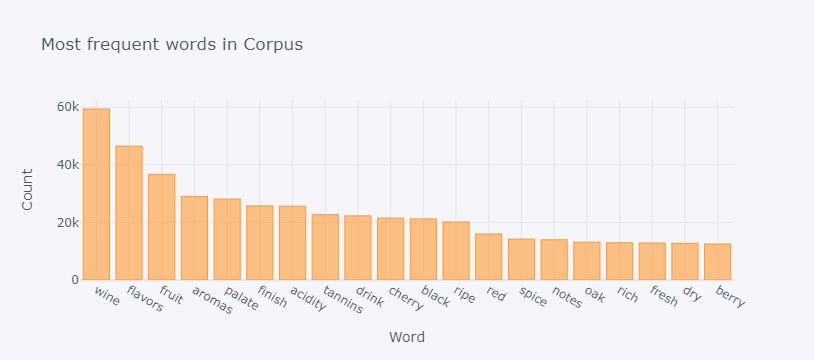

In [520]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

#### choosing vocabulary size with regards to number of records

In [521]:
new_size = words_df[words_df.wordCount >= 5].shape[0]
tr_size = words_df.shape[0]
tr_rec = train_data.shape[0]
print("Number of unique words in training dataset: {}".format(tr_size))
print("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(new_size))
print(f'propotion of new vocabulary from all training unique words is {new_size/tr_size:.3f}')
print("Number of records in training dataset: {}".format(tr_rec))
print(f'features vs records in training dataset: {new_size/tr_rec:.3f}')

Number of unique words in training dataset: 27977
Using words with 5 or more appearnces will reduce the corpus size to: 10686
propotion of new vocabulary from all training unique words is 0.382
Number of records in training dataset: 95990
features vs records in training dataset: 0.111


In [522]:
new_size = words_df[words_df.wordCount >= 2].shape[0]
tr_size = words_df.shape[0]
tr_rec = train_data.shape[0]
print("Number of unique words in training dataset: {}".format(tr_size))
print("Using words with 2 or more appearnces will reduce the corpus size to: {}".format(new_size))
print(f'propotion of new vocabulary from all training unique words is {new_size/tr_size:.3f}')
print("Number of records in training dataset: {}".format(tr_rec))
print(f'features vs records in training dataset: {new_size/tr_rec:.3f}')

Number of unique words in training dataset: 27977
Using words with 2 or more appearnces will reduce the corpus size to: 17679
propotion of new vocabulary from all training unique words is 0.632
Number of records in training dataset: 95990
features vs records in training dataset: 0.184


In [523]:
# we can see that ~40% of words appear once

#### BoW - Sparse Matrix representation

In [548]:
#defining the vocabulary:
#from train data only and appeared n_appear or above
#choosing 5 - as smaller may lead to overfit
n_appear = 2
vocab = set(words_df[words_df.wordCount >= n_appear].word) #set of all the words in vocab that appear n_appear or more

In [549]:
len(vocab) #for 5 ->10686

17679

In [550]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [551]:
# sparse matrixes from train and test df
count_vect = CountVectorizer(vocabulary = vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_data.clean_desc)
test_bow_counts = count_vect.fit_transform(test_data.clean_desc)
assert(train_bow_counts.shape[0] + test_bow_counts.shape[0]  == wines.shape[0])
print('train:', train_bow_counts.shape[0], ' + test:',test_bow_counts.shape[0], ' = ', wines.shape[0])

train: 95990  + test: 23998  =  119988


### ridgeCV on BoW

In [552]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error

In [553]:
#use ridge with CV built in; cv=10 fold; try alphas in the list
#source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

Ridge_clf = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0, 1000.0), cv=10)

In [554]:
#fit the model on train data
Ridge_clf.fit(train_bow_counts, y = train_data.points)

RidgeCV(alphas=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), cv=10)

In [555]:
#predict on test data
test_data['ridge_NLP'] = Ridge_clf.predict(test_bow_counts)

In [556]:
calc_prediction_quality(test_data, 'ridge_NLP','points')

MSE    2.981654
MAE    1.361290
R2     0.687266
dtype: float64

In [ ]:
# for appearance >= 5; not using clean_text
# MSE    3.087962
# MAE    1.387830
# R2     0.676116
# dtype: float64

# using clean_text (appearance >= 5)
# MSE    2.996614
# MAE    1.364713
# R2     0.685697
# dtype: float64

#using clean_text appearnace >= 2
# MSE    2.981654
# MAE    1.361290
# R2     0.687266
# dtype: float64

### trying neural networks on BoW

In [557]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping

In [444]:
#embedding_dim = 300 #defined earlier based on external file
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 30
mloss = 'mse'
n_lr = 3e-4
active_f = 'tanh'

In [445]:
#create model
#using reshape to concat the vectors - should add also more info on order of words
#replaced embedding layer with pre-build embedding built using Glove external embedding
model = tf.keras.Sequential([
    Dense(nn, activation=active_f, input_dim=len(vocab)+2, name='hi_layer'),
    Dropout(ndropout),
    Dense(1, name = 'output_layer')
])

In [446]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [447]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding_12 (Embedding)    (None, 72, 300)           8394900   
                                                                 
 concat_words (Reshape)      (None, 21600)             0         
                                                                 
 hidden_layer (Dense)        (None, 820)               17712820  
                                                                 
 dropout_15 (Dropout)        (None, 820)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 821       
                                                     

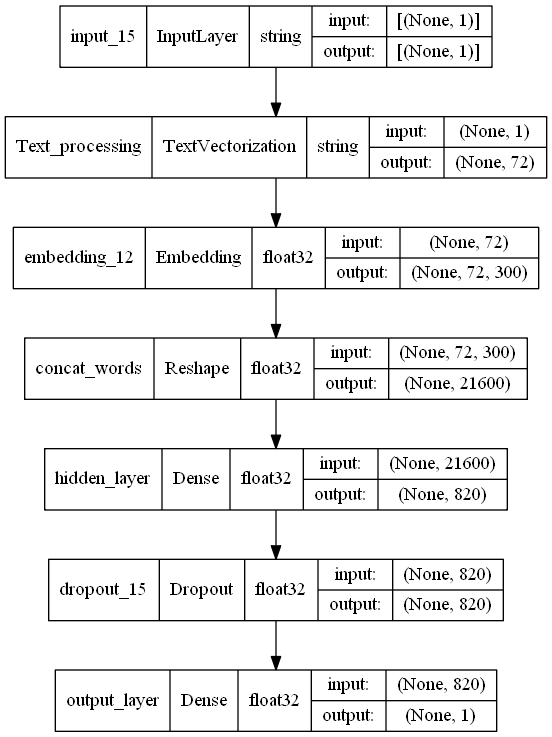

In [448]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [449]:
%%time
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
3000/3000 [==============================] - 428s 142ms/step - loss: 98.2748 - mean_squared_error: 98.2748 - mean_absolute_error: 4.8800 - val_loss: 4.5303 - val_mean_squared_error: 4.5303 - val_mean_absolute_error: 1.6816
Epoch 2/30
3000/3000 [==============================] - 450s 150ms/step - loss: 6.6281 - mean_squared_error: 6.6281 - mean_absolute_error: 2.0455 - val_loss: 3.8985 - val_mean_squared_error: 3.8985 - val_mean_absolute_error: 1.5638
Epoch 3/30
3000/3000 [==============================] - 402s 134ms/step - loss: 6.2271 - mean_squared_error: 6.2271 - mean_absolute_error: 1.9853 - val_loss: 3.9867 - val_mean_squared_error: 3.9867 - val_mean_absolute_error: 1.5792
Epoch 4/30
3000/3000 [==============================] - 399s 133ms/step - loss: 5.8982 - mean_squared_error: 5.8982 - mean_absolute_error: 1.9316 - val_loss: 3.7642 - val_mean_squared_error: 3.7642 - val_mean_absolute_error: 1.5342
Epoch 5/30
3000/3000 [==============================] - 382s 127ms/ste

In [450]:
test_data['ext_embedding'] = model.predict(test_data[text_col])

In [451]:
calc_prediction_quality(test_data, 'ext_embedding', target_col)

MSE    3.764231
MAE    1.534216
R2     0.605185
dtype: float64

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject



In [117]:
#create early stopping callback
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

In [118]:
model = Sequential()
model.add(Dense(768, input_dim=8))
model.add(Activation('tanh'))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)

In [119]:
#more complex models - did not achieve better results
# model = Sequential()
# model.add(Dense(256, input_dim=8, activation='tanh'))
# model.add(Dense(128, activation='tanh'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(1))

# optimizer = Adam(learning_rate=0.001)
# model.compile(loss='mse', optimizer=optimizer)

In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


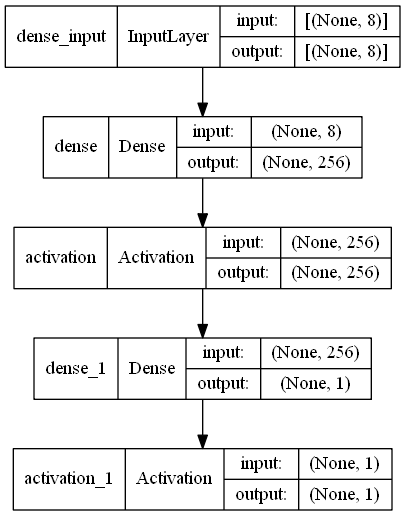

In [121]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [122]:
model.fit(train_enc, train_y, validation_data=(test_enc, test_y),
          batch_size=50, epochs=100, verbose=True, callbacks=[early_stopping_monitor])

Epoch 1/100
1920/1920 [==============================] - 3s 1ms/step - loss: 536.6515 - val_loss: 9.6225
Epoch 2/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.6237 - val_loss: 9.5804
Epoch 3/100
1920/1920 [==============================] - 2s 1ms/step - loss: 9.5864 - val_loss: 9.5489
Epoch 4/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.5887 - val_loss: 9.5266
Epoch 5/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.5926 - val_loss: 9.5250s - loss: 9
Epoch 6/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.5741 - val_loss: 9.5826
Epoch 7/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.4756 - val_loss: 9.4321
Epoch 8/100
1920/1920 [==============================] - 3s 1ms/step - loss: 9.2745 - val_loss: 8.4967
Epoch 9/100
1920/1920 [==============================] - 3s 1ms/step - loss: 8.7948 - val_loss: 8.1876
Epoch 10/100
1920/1920 [==============================] - 3s

In [123]:
test_predict = pd.DataFrame()
test_predict['points'] = test_y
test_predict['neuron network'] = model.predict(test_enc)

In [124]:
#check stats and add to comparison df
neuron_nwk_stats = calc_prediction_quality(test_predict, 'neuron network','points')
all_compared = all_compared.append(neuron_nwk_stats.to_frame(name='neuron network no txt').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.534919,2.531565,-0.000079
baseline_2,9.065662,2.466277,0.049139
baseline_3,8.512676,2.370454,0.107140
regression_by_xgb,6.211226,1.889199,0.348529
ridge linear reg,7.849773,2.272732,0.176669
ridge_no_price,9.482293,2.517509,0.005440
ridge_mean_price,7.810355,2.267187,0.180803
knn,6.319297,1.962514,0.337194
bow_linear_reg,3.019525,1.371023,0.683294
united_bow_enc_l_reg,2.853323,1.330968,0.700726


## Bonus  - Trials - (Keras functional API)

See here: https://keras.io/guides/functional_api/

In [365]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [366]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 3 #30
mloss = 'mse'
n_lr = 1e-3
active_f = 'tanh'

#
scaled_test_df = scaled_test_df.iloc[:,0:8]


In [367]:
#params:
#vectorize_layer TextVectorization
#vocab_size = 32000
#sequence_length = 72 #60

#using the kerashape=unctional API to build a model with 2 inputs
#descrption text embedding
desc_input = keras.Input(shape=(1,), dtype="string", name="text")
token_input = vectorize_layer(desc_input)
desc_features = layers.Embedding(vocab_size, 16)(token_input)
#desc_features = layers.LSTM(128, name='text_LSTM')(desc_features)
desc_features = Bidirectional(LSTM(64))(desc_features)
desc_features = Dense(64, activation='relu', name='LSTM_hidden')(desc_features)
#other data
other_input = keras.Input(shape=(8,), name="other")
other_features = layers.Dense(32, name="other_hidden")(other_input)
#concatenate
x = layers.concatenate([desc_features, other_features])
#hidden layer
hidden = layers.Dense(96, name="unified_hidden")(x)
#output
points_pred = layers.Dense(1, name="points_prediction")(hidden)
# Instantiate an end-to-end model from both
model1 = keras.Model(
    inputs=[desc_input, other_input],
    outputs=[points_pred],
)


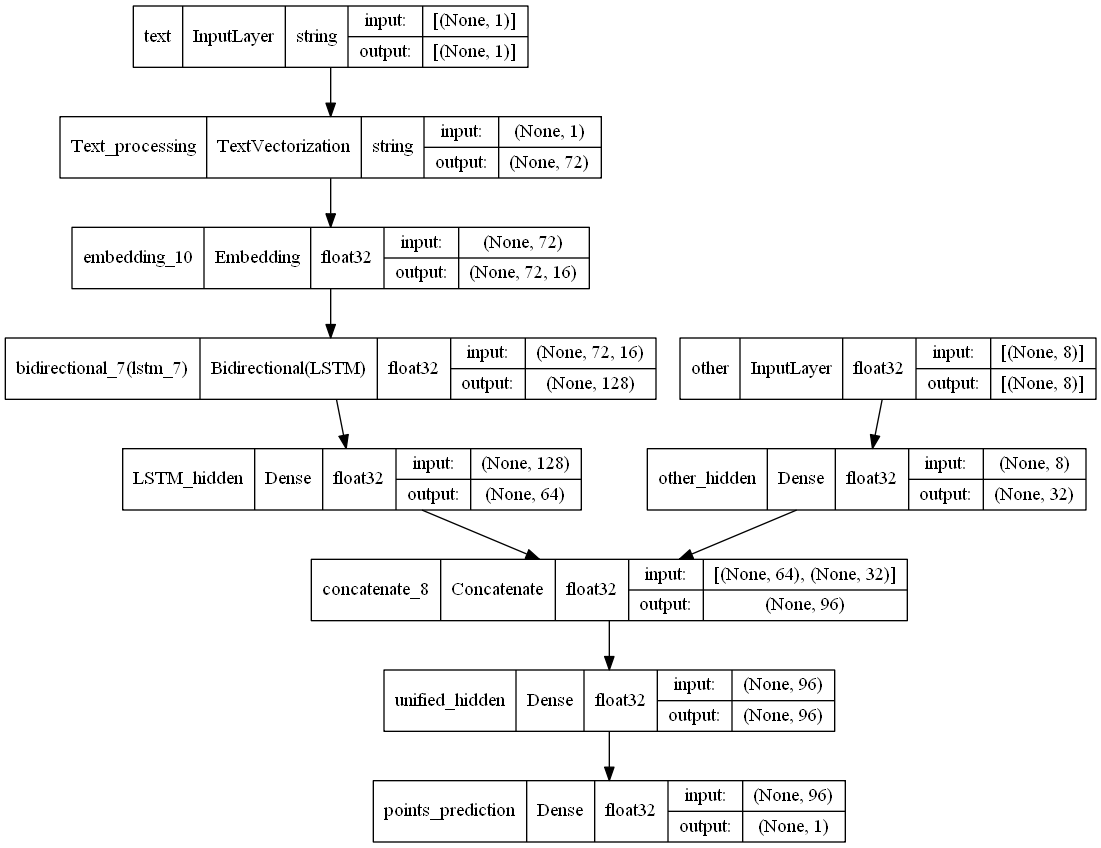

In [368]:
tf.keras.utils.plot_model(model1, show_dtype=True, show_shapes=True, show_layer_names=True)

In [369]:
model1.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Text_processing (TextVectoriza  (None, 72)          0           ['text[0][0]']                   
 tion)                                                                                            
                                                                                                  
 embedding_10 (Embedding)       (None, 72, 16)       512000      ['Text_processing[20][0]']       
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 128)         41472       ['embedding_10[0][0]']     

In [370]:
#compile the model
optimizer = Adam(learning_rate=n_lr)
model1.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [371]:
%%time
#for text data
text_col, target_col = 'clean_desc', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    min_delta=0,
    patience=5, #3
    verbose=0,
    restore_best_weights=True
)

history = model1.fit(
    x=[train_data[text_col], scaled_train_df],
    y=train_y,
    epochs=nepochs,
    batch_size=nbatch,
    verbose=True, 
    callbacks=[early_stopping],
    validation_data=[[test_data[text_col], scaled_test_df], test_y]
)
#see
#https://stackoverflow.com/questions/46125729/cant-pass-validation-data-to-a-model-with-several-inputs-in-keras

Epoch 1/3
3000/3000 [==============================] - 478s 154ms/step - loss: 66.5171 - mean_squared_error: 66.5171 - mean_absolute_error: 2.9458 - val_loss: 6.1435 - val_mean_squared_error: 6.1435 - val_mean_absolute_error: 1.9706
Epoch 2/3
3000/3000 [==============================] - 484s 161ms/step - loss: 3.8714 - mean_squared_error: 3.8714 - mean_absolute_error: 1.5319 - val_loss: 4.2949 - val_mean_squared_error: 4.2949 - val_mean_absolute_error: 1.6761
Epoch 3/3
3000/3000 [==============================] - 445s 148ms/step - loss: 2.9219 - mean_squared_error: 2.9219 - mean_absolute_error: 1.3404 - val_loss: 2.7390 - val_mean_squared_error: 2.7390 - val_mean_absolute_error: 1.3043
Wall time: 23min 26s


In [372]:
scaled_test_df = scaled_test_df.iloc[:,0:8]
#scaled_test_df.head(1)

In [373]:
#preds_prob = model.predict([X_test_feature1, X_test_feature2])
scaled_test_df['unified_keras_api'] = model1.predict([test_data[text_col], scaled_test_df])

In [374]:
scaled_test_df['points'] = test_y

In [375]:
calc_prediction_quality(scaled_test_df, 'unified_keras_api', target_col)

MSE    2.739016
MAE    1.304255
R2     0.712716
dtype: float64

In [130]:
# trying to solve utf8 issue
#wine_utf8= pd.read_csv("data/winemag-data-130k-v2utf8.csv")
wine_utf8= pd.read_csv("data/winemag-data-130k-v2utf8.csv", encoding='latin-1')
wine_utf8.shape
#pd.read_csv(r'C:\path\to\file.csv', sep='|', encoding = "ISO-8859-1")
#data = pd.read_csv(filename, encoding= 'unicode_escape')
#data = pd.read_csv("filename.csv", encoding='cp1252') -> cannot read_csv
#pd.read_csv('ml-100k/u.item', sep='|', names=m_cols , encoding='latin-1')

(129971, 14)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [138]:
#text to lowercase
wine_utf8['description'] = wines.description.apply(lambda x: x.lower())
#wine_utf8['description'] = wines.description.apply(lambda x: x.encode('utf-8'))
wine_utf8.description.sample(1)

87003    from the producer's original, own-rooted 1965 ...
Name: description, dtype: object

In [139]:
train_data = wine_utf8.sample(frac = 0.8)
test_data = wine_utf8[~wine_utf8.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_utf8))

In [140]:
len(test_data), len(train_data)

(25994, 103977)

In [141]:
#imports
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout

#### Tokenization

In [142]:
#see the function signiture of TextVectorization
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
)

What is a good size for a 'sentence' (tokens per record/description)? 

In [143]:
wine_utf8.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    71.0
Name: description, dtype: float64

In [144]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [145]:
#Compute a vocabulary of string terms from tokens in a dataset.
vectorize_layer.adapt(train_data['description'])

In [146]:
#see a description broken into tokens vs the vector representation
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

this inzolia offers clean and fresh aromas of citrus, peach, white flower and garden herb. a subtle touch of sweetness is found on the palate.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([   7, 4436,   52,  130,    2,   39,   17,    5,   60,   79,   55,
        244,    2, 2300,  100,    4,  290,   78,    5,  305,    8, 1341,
         15,    3,   18,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [147]:
# for token in vectorize_layer(sample_description).numpy()[:20]:
#     print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])
#codec-8 error -> skipping

#### Modeling

In [148]:
embedding_dim=16

model = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [149]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout_1 (Dropout)         (None, 164)              

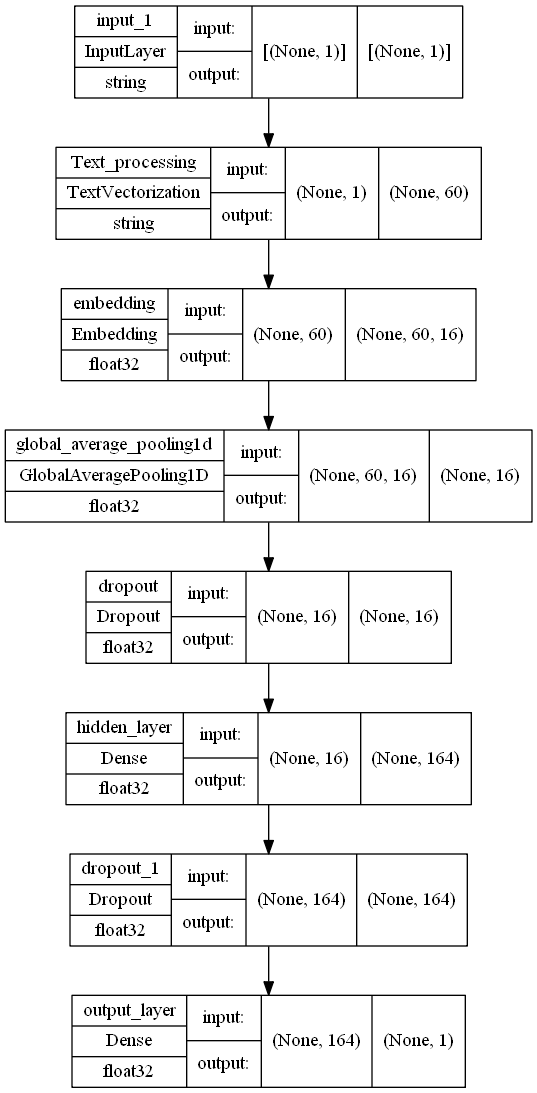

In [150]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [151]:
optimizer = Adam()
#model.compile(loss=tf.keras.losses.MeanSquaredError, optimizer=optimizer)
model.compile(loss='mse', optimizer=optimizer)

In [152]:
model.fit(train_data.description, train_y, validation_data=(test_data.description, test_y),
          batch_size=50, epochs=100, verbose=True)#, callbacks=[early_stopping]) #removed early stopping due to utf8 error

Epoch 1/100
2080/2080 [==============================] - 22s 10ms/step - loss: 551.9943 - val_loss: 9.8295
Epoch 2/100
2080/2080 [==============================] - 22s 11ms/step - loss: 22.5200 - val_loss: 9.4524
Epoch 3/100
2080/2080 [==============================] - 23s 11ms/step - loss: 21.4407 - val_loss: 9.6027
Epoch 4/100
2080/2080 [==============================] - 24s 12ms/step - loss: 21.1979 - val_loss: 9.3750
Epoch 5/100
2080/2080 [==============================] - 25s 12ms/step - loss: 21.0894 - val_loss: 9.3573
Epoch 6/100
2080/2080 [==============================] - 24s 11ms/step - loss: 20.9063 - val_loss: 9.4134
Epoch 7/100
2080/2080 [==============================] - 26s 13ms/step - loss: 20.8005 - val_loss: 9.5353
Epoch 8/100
2080/2080 [==============================] - 26s 13ms/step - loss: 20.7085 - val_loss: 9.3420
Epoch 9/100
2080/2080 [==============================] - 26s 12ms/step - loss: 20.6569 - val_loss: 9.3923
Epoch 10/100
2080/2080 [=====================

In [159]:
test_data['NN on Text'] = model.predict(test_data.description)

ValueError: in user code:

    File "C:\Users\oshepon\Anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\oshepon\Anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\oshepon\Anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\oshepon\Anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\oshepon\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\oshepon\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 29096, but received input with shape (None, 1)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=False
      • mask=None


In [109]:
test_data['points'] = test_y

In [110]:
test_data.sample(1)

,country,province,region_1,region_2,taster_name,variety,winery,price,neuron network,points
34852,37,349,738,6,10,561,1561,-1.0,87.456642,92


In [111]:
#check stats and add to comparison df
neuron_nwk_stats = calc_prediction_quality(test_data, 'NN on Text','points')
all_compared = all_compared.append(neuron_nwk_stats.to_frame(name='neuron network').transpose())
all_compared

,MSE,MAE,R2
baseline_1,9.332718,2.504915,-0.000102
baseline_2,8.872909,2.437268,0.049171
baseline_3,8.324619,2.343284,0.107927
regression_by_xgb,6.101870,1.864815,0.346118
ridge linear reg,7.949187,2.239467,0.148158
knn,6.080463,1.921374,0.348412
bow_linear_reg,2.860830,1.334814,0.693431
united_bow_enc_l_reg,2.861189,1.334851,0.693393
united_bow_enc_l_reg,2.861189,1.334851,0.693393
neuron network,7.311602,2.172896,0.216482


In [86]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [ ]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

In [320]:
from platform import python_version

In [321]:
python_version()

'3.8.8'

### NN on Text (Embeddings) take 2 - using tensorflow.data

In [6]:
#source: https://medium.com/deep-learning-with-keras/text-vectorization-use-save-upload-54d65945d222

#### Imports

In [38]:
#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import re
import string
import random
from sklearn.model_selection import train_test_split
print("tf version:",tf.__version__)
print("keras version:", keras.__version__)

#@title Record Each Cell's Execution Time
#!pip install ipython-autotime

%load_ext autotime

tf version: 2.7.0
keras version: 2.7.0
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-05-14 18:55:00 +03:00)


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oshepon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

time: 1.3 s (started: 2022-05-14 18:50:22 +03:00)


#### Stopwords

In [11]:
##stopwords
# already done above
stopwords=nltk.corpus.stopwords.words("english")

for each in stopwords[:10]:
    print(each)

i
me
my
myself
we
our
ours
ourselves
you
you're
time: 0 ns (started: 2022-05-14 18:50:36 +03:00)


#### Know the Data

In [12]:
#wines = wine_reviews.copy()

time: 0 ns (started: 2022-05-14 18:50:44 +03:00)


In [13]:
###########replace from above
wines = wine_reviews.drop_duplicates()
print(wine_reviews.shape)
print(wines.shape)

(119988, 13)
(119988, 13)
time: 343 ms (started: 2022-05-14 18:50:45 +03:00)


In [14]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB
time: 63 ms (started: 2022-05-

In [15]:
wines.isnull().sum()

country                     59
description                  0
designation              34545
points                       0
price                     8395
province                    59
region_1                 19560
region_2                 73219
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

time: 62 ms (started: 2022-05-14 18:50:46 +03:00)


In [16]:
#wines.dropna(inplace=True) -> removing all NAs -> ~130,000 records to ~22,000
##### actually no need to drop anything as no nulls in 'description' nor in 'points'

time: 0 ns (started: 2022-05-14 18:50:46 +03:00)


#### Remove before final run - reduce data size for the tryouts

In [55]:
#limit the number of samples to be used in testing the pipeline
#data_size= 1000         #comment for final run    
#data= wines[:data_size] #comment for final run
data = wines           #UNcomment for final run
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB
time: 78 ms (started: 2022-05-

#### Split Training and Test Data and TensorFlow Datasets

In [56]:
#split training and test data
# save features and targets from the 'data'
features, targets = data['description'], data['points']

train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        random_state=42,
        shuffle = True,
        #stratify=targets
    )

time: 32 ms (started: 2022-05-14 19:00:51 +03:00)


In [57]:
test_features.iloc[0], test_targets.iloc[0]

("Produced for the owner of Château Cos d'Estournel in Bordeaux, this wine was wood-aged before undergoing its second fermentation. That gives it a rich, creamy character, attractively oxidative while also having fresh apple and citrus flavors. It's an intense, complex wine that has been bottled ready to drink, marking a very fine launch.",
 94)

time: 0 ns (started: 2022-05-14 19:00:51 +03:00)


In [58]:
# TensorFlow Data Set
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_features.values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_targets.values, tf.int64),
) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_features.values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_targets.values, tf.int64),
)

time: 47 ms (started: 2022-05-14 19:00:51 +03:00)


In [59]:
type(train_cat_ds_raw)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

time: 0 ns (started: 2022-05-14 19:00:51 +03:00)


#### Vocabulary

In [60]:
vocab_size = 20000  # Only consider the top 20K words
max_len = 60  # Maximum review (text) size in words (we saw 95% are 60 and below)

time: 0 ns (started: 2022-05-14 19:00:52 +03:00)


#### Define own custom_standardization function

In [61]:
#@tf.keras.utils.register_keras_serializable() #need to uncomment after kernel restart/jupyter start???
def custom_standardization3(input_string):
    """ Remove html line-break tags and handle punctuation """
    no_uppercased = tf.strings.lower(input_string, encoding='utf-8')
    no_stars = tf.strings.regex_replace(no_uppercased, "\*", " ")    
    no_html = tf.strings.regex_replace(no_stars, "<br />", "")
    no_digits = tf.strings.regex_replace(no_html, "\w*\d\w*","")
    no_punctuations = tf.strings.regex_replace(no_digits, f"([{string.punctuation}])", r" ")
    #remove stop words
    no_stop_words = ' '+no_punctuations+ ' '
    for each in stopwords:
        no_stop_words = tf.strings.regex_replace(no_stop_words, ' '+each+' ' , r" ")
        no_extra_space = tf.strings.regex_replace(no_stop_words, " +"," ")

    return no_extra_space

#how to unregister custom function? so we can make changes

time: 0 ns (started: 2022-05-14 19:00:52 +03:00)


In [62]:
input_string = train_features.iloc[0]
print("input:  ", input_string)
print()
output_string= custom_standardization3(input_string)
print("output: ", output_string.numpy().decode("utf-8"))

input:   Sleek and elegant, showing a great sense of control, the cherry and currant fruits are strong, yet restrained, pulled in by crisp acidity and taut tannins. It should develop over the next six years or so.

output:   sleek elegant showing great sense control cherry currant fruits strong yet restrained pulled crisp acidity taut tannins develop next six years 
time: 0 ns (started: 2022-05-14 19:00:52 +03:00)


#### Vectorization Layer

In [74]:
# Create a vectorization layer and adapt it to the text (training data only)
vectorize_layer = TextVectorization(
    standardize=custom_standardization3,
    #max_tokens=vocab_size+2,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=max_len,
)

#more info
# standardize - custom_standardizationX() function we built above (can use also "lower_and_strip_punctuation")
# max_tokens is the maximum size of the vocabulary that will be created from the dataset
# output_mode - one integer index per split string token. When output_mode == “int”, 
#    0 is reserved for masked locations; this reduces the vocab size to max_tokens — 2 instead of max_tokens — 1.
#    for “int” output, any shape of input and output is supported.

time: 0 ns (started: 2022-05-14 19:08:02 +03:00)


In [75]:
vectorize_layer.adapt(train_features)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

time: 17.4 s (started: 2022-05-14 19:08:04 +03:00)


In [76]:
#check conversions:
print("vocab has the ", len(vocab)," entries")
print("vocab has the following first 10 entries")
for word in range(10):
    print(word, " represents the word: ", vocab[word])

for X in train_features[:2]:
    print(" Given raw data: " )
    print(X)
    tokenized = vectorize_layer(tf.expand_dims(X, -1))
    print(" Tokenized and Transformed to a vector of integers: " )
    print (tokenized)
    print(" Text after Tokenized and Transformed: ")
    transformed = ""
    for each in tf.squeeze(tokenized):
        transformed= transformed+ " "+ vocab[each]
    print(transformed)

vocab has the  20000  entries
vocab has the following first 10 entries
0  represents the word:  
1  represents the word:  [UNK]
2  represents the word:  wine
3  represents the word:  flavors
4  represents the word:  fruit
5  represents the word:  aromas
6  represents the word:  palate
7  represents the word:  finish
8  represents the word:  acidity
9  represents the word:  tannins
 Given raw data: 
Sleek and elegant, showing a great sense of control, the cherry and currant fruits are strong, yet restrained, pulled in by crisp acidity and taut tannins. It should develop over the next six years or so.
 Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[1078  116  172  115  357 1855   11   71   27  207  120  501 3098   33
     8  519    9  328  286  651   59    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 60), d

#### future - save and load model

#### Apply keras TextVectorization to train and test sets

In [77]:
#We can define a function to apply the Keras TextVectorization on a given string 
def convert_text_input(sample):
    text = sample
    text = tf.expand_dims(text, -1)  
    return tf.squeeze(vectorize_layer(text))
    #return tf.squeeze(loaded_vectorize_layer(text))

time: 0 ns (started: 2022-05-14 19:08:38 +03:00)


In [78]:
# We use the TensorFlow tf.data API (TF Data Pipeline) map() funtion to apply convert_text_input()
#   on every sample in the text column (reviews) of the training dataset.
# Train X
train_text_ds = train_text_ds_raw.map(convert_text_input, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Test X
test_text_ds = test_text_ds_raw.map(convert_text_input, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
#check converted/encoded text reviews
for each in train_text_ds.take(2):
    print(each)

tf.Tensor(
[1078  116  172  115  357 1855   11   71   27  207  120  501 3098   33
    8  519    9  328  286  651   59    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(60,), dtype=int64)
tf.Tensor(
[   5  199 5756 2493  136  416 4053  590   24   20   14    4    3 2595
    7 1814    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(60,), dtype=int64)
time: 516 ms (started: 2022-05-14 19:08:41 +03:00)


In [80]:
#combine feature and target for train and test (seperatly)
train_ds = tf.data.Dataset.zip((train_text_ds, train_cat_ds_raw))
test_ds = tf.data.Dataset.zip((test_text_ds, test_cat_ds_raw))

time: 0 ns (started: 2022-05-14 19:08:48 +03:00)


In [81]:
#check the data
for X,y in train_ds.take(1):
    print("input (review) X.shape: ", X.shape)
    print("output (category) y.shape: ", y.shape)
    print("input (review) X: ", X)
    print("output (category) y: ",y)
    input = " ".join([vocab[_] for _ in np.squeeze(X)])
    print("X: input (review) in text: " , input)
    print("y: output (category) in text: " , y.numpy())

input (review) X.shape:  (60,)
output (category) y.shape:  ()
input (review) X:  tf.Tensor(
[1078  116  172  115  357 1855   11   71   27  207  120  501 3098   33
    8  519    9  328  286  651   59    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(60,), dtype=int64)
output (category) y:  tf.Tensor(91, shape=(), dtype=int64)
X: input (review) in text:  sleek elegant showing great sense control cherry currant fruits strong yet restrained pulled crisp acidity taut tannins develop next six years                                       
y: output (category) in text:  91
time: 109 ms (started: 2022-05-14 19:08:52 +03:00)


In [82]:
# Finalize TensorFlow Data Pipeline by setting necessary parameters for batching, shuffling, and optimizing
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size= train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

time: 0 ns (started: 2022-05-14 19:08:55 +03:00)


#### Creating the Model

In [83]:
#model
def create_model():
    inputs_tokens = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_layer = layers.Embedding(vocab_size, 256)
    x = embedding_layer(inputs_tokens)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs_tokens, outputs=outputs)
    
    loss_fn = tf.keras.losses.MeanSquaredError()
    metric_fn  = tf.keras.metrics.MeanSquaredError()
    model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)  
    
    return model
my_model=create_model()
my_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 60, 256)           5120000   
                                                                 
 flatten_2 (Flatten)         (None, 15360)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 15361     
                                                                 
Total params: 5,135,361
Trainable params: 5,135,361
Non-trainable params: 0
_________________________________________________________________
time: 62 ms (started: 2022-05-14 19:09:01 +03:00)


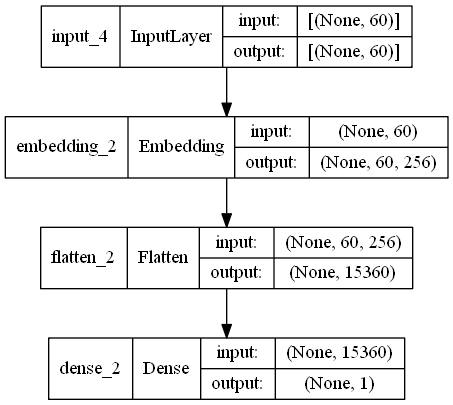

time: 234 ms (started: 2022-05-14 20:32:30 +03:00)


In [105]:
tf.keras.utils.plot_model(my_model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [84]:
#Train the Classification Model
my_model.fit(train_ds, verbose=1, epochs=3, )

Epoch 1/3
1499/1499 [==============================] - 136s 84ms/step - loss: 212.7757 - mean_squared_error: 212.7757
Epoch 2/3
1499/1499 [==============================] - 127s 85ms/step - loss: 3.4710 - mean_squared_error: 3.4710
Epoch 3/3
1499/1499 [==============================] - 142s 95ms/step - loss: 2.7460 - mean_squared_error: 2.7460


time: 6min 45s (started: 2022-05-14 19:09:05 +03:00)


In [85]:
#define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

time: 0 ns (started: 2022-05-14 19:57:46 +03:00)


In [86]:
#Trying with validation_data and early_stopping 
my_model.fit(train_ds, validation_data=(test_ds), epochs=20, verbose=True, callbacks=[early_stopping]) #removed early stopping due to utf8 error

Epoch 1/20
1499/1499 [==============================] - 136s 91ms/step - loss: 2.2727 - mean_squared_error: 2.2727 - val_loss: 3.4970 - val_mean_squared_error: 3.4970
Epoch 2/20
1499/1499 [==============================] - 129s 86ms/step - loss: 1.7644 - mean_squared_error: 1.7644 - val_loss: 3.8412 - val_mean_squared_error: 3.8412
Epoch 3/20
1499/1499 [==============================] - 123s 82ms/step - loss: 1.4571 - mean_squared_error: 1.4571 - val_loss: 4.5689 - val_mean_squared_error: 4.5689
Epoch 4/20
1499/1499 [==============================] - 126s 84ms/step - loss: 1.6756 - mean_squared_error: 1.6756 - val_loss: 5.3948 - val_mean_squared_error: 5.3948
Epoch 5/20
1499/1499 [==============================] - 126s 84ms/step - loss: 1.9127 - mean_squared_error: 1.9127 - val_loss: 4.5368 - val_mean_squared_error: 4.5368
Epoch 6/20
1499/1499 [==============================] - 129s 86ms/step - loss: 1.7247 - mean_squared_error: 1.7247 - val_loss: 5.8662 - val_mean_squared_error: 5.866

time: 12min 48s (started: 2022-05-14 19:57:53 +03:00)


#### Predict - ???

In [87]:
# predict???
# need to overcome shuffling of data to compare to actuals
arr = my_model.predict(test_ds)
print(arr.size, test_targets.size)

23936 23998
time: 953 ms (started: 2022-05-14 20:13:24 +03:00)


#### Creating E2E model for text input

In [88]:
inputs = keras.Input(shape=(1,), dtype="string")
x = vectorize_layer(inputs)
outputs = my_model(x)
end_to_end_model = keras.Model(inputs, outputs)
loss_fn = tf.keras.losses.MeanSquaredError()
metric1_fn  = tf.keras.metrics.MeanSquaredError()
metric2_fn  = tf.keras.metrics.MeanAbsoluteError()
end_to_end_model.compile(loss=loss_fn, optimizer="adam", metrics=[ metric2_fn])
end_to_end_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 60)               0         
 ectorization)                                                   
                                                                 
 model_3 (Functional)        (None, 1)                 5135361   
                                                                 
Total params: 5,135,361
Trainable params: 5,135,361
Non-trainable params: 0
_________________________________________________________________
time: 141 ms (started: 2022-05-14 20:13:41 +03:00)


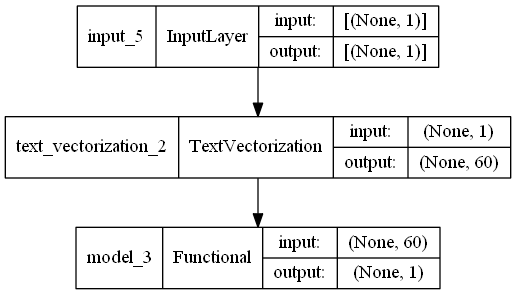

time: 235 ms (started: 2022-05-14 20:33:07 +03:00)


In [106]:
tf.keras.utils.plot_model(end_to_end_model, show_dtype=False, show_shapes=True, show_layer_names=True)

#### Predict from E2E Model

In [89]:
test_features.iloc[0], test_targets.iloc[0]

("Produced for the owner of Château Cos d'Estournel in Bordeaux, this wine was wood-aged before undergoing its second fermentation. That gives it a rich, creamy character, attractively oxidative while also having fresh apple and citrus flavors. It's an intense, complex wine that has been bottled ready to drink, marking a very fine launch.",
 94)

time: 0 ns (started: 2022-05-14 20:13:48 +03:00)


In [90]:
#test some raw data
raw_data=[test_features.iloc[0]]
predictions=end_to_end_model.predict(raw_data)
predictions[0][0]

88.81795

time: 313 ms (started: 2022-05-14 20:13:50 +03:00)


In [91]:
#evaluate the model
end_to_end_model.evaluate(test_features,test_targets)

750/750 [==============================] - 7s 9ms/step - loss: 3.4983 - mean_absolute_error: 1.4522


[3.498295783996582, 1.45219087600708]

time: 6.77 s (started: 2022-05-14 20:14:05 +03:00)


In [92]:
#predict from the model
emb_predict= end_to_end_model.predict(test_features)

time: 5.84 s (started: 2022-05-14 20:14:18 +03:00)


In [93]:
#make a list from predictions
emb_pred_lst = []
for i in emb_predict:
    emb_pred_lst.append(i[0])
#make df from 'points' and predictions
embd_results = pd.DataFrame(test_targets, columns=['points'])
embd_results['embd_pred'] = emb_pred_lst
embd_results.sample(5)

,points,embd_pred
3796,88,88.690086
53401,90,89.355537
33272,87,86.139275
111945,85,83.965950
98534,88,87.098259


time: 16 ms (started: 2022-05-14 20:14:28 +03:00)


In [94]:
#calculate model results
embd_stats = calc_prediction_quality(embd_results, 'embd_pred','points')
print(embd_stats)
all_compared = all_compared.append(embd_stats.to_frame(name='NN embeddings').transpose())
all_compared

MSE    3.498310
MAE    1.452194
R2     0.632246
dtype: float64


NameError: name 'all_compared' is not defined

time: 16 ms (started: 2022-05-14 20:14:50 +03:00)


## Create E2E more complex - Fully Connected (mean word per review)

In [128]:
train_data = wines.sample(frac = 0.8)
test_data = wines[~wines.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wines))

time: 110 ms (started: 2022-05-14 21:16:44 +03:00)


In [129]:
 len(train_data), len(test_data)

(95990, 23998)

time: 0 ns (started: 2022-05-14 21:16:44 +03:00)


In [130]:
#embedding_dim=16
embedding_dim=128

emb_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

#Embedding(vocab_size, embedding_dim, name="embedding")
#    input_dim=vocab_size, output_dim=embedding_dim (the dim for the dense word vector) 
#GlobalAveragePooling1D()
#    Averages the words in each review (it reduces 1 dimension)
#    60*16 (each word*embedding_dim) -> average the words -> (1*16)

time: 218 ms (started: 2022-05-14 21:16:44 +03:00)


In [131]:
emb_model.compile(
    optimizer=tf.optimizers.Adam(), 
    loss='mean_absolute_error', 
    metrics=['mean_squared_error','mean_absolute_error']
)

time: 0 ns (started: 2022-05-14 21:16:45 +03:00)


In [132]:
emb_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 60)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 60, 128)           2560000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               21156     
                                                                 
 dropout_3 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

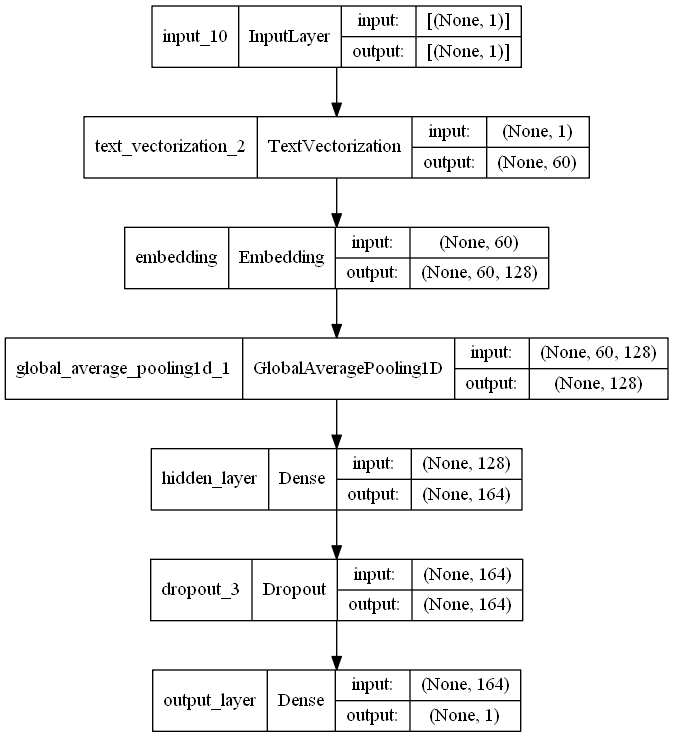

time: 266 ms (started: 2022-05-14 21:16:45 +03:00)


In [133]:
tf.keras.utils.plot_model(emb_model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [134]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = emb_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 53s 70ms/step - loss: 20.5702 - mean_squared_error: 1074.4510 - mean_absolute_error: 20.5702 - val_loss: 2.5282 - val_mean_squared_error: 9.6987 - val_mean_absolute_error: 2.5282
Epoch 2/20
750/750 [==============================] - 52s 69ms/step - loss: 3.7242 - mean_squared_error: 21.6283 - mean_absolute_error: 3.7242 - val_loss: 2.5146 - val_mean_squared_error: 9.7223 - val_mean_absolute_error: 2.5146
Epoch 3/20
750/750 [==============================] - 52s 69ms/step - loss: 3.7011 - mean_squared_error: 21.3621 - mean_absolute_error: 3.7011 - val_loss: 2.5124 - val_mean_squared_error: 9.4879 - val_mean_absolute_error: 2.5124
Epoch 4/20
750/750 [==============================] - 52s 69ms/step - loss: 3.3725 - mean_squared_error: 17.9275 - mean_absolute_error: 3.3725 - val_loss: 1.5041 - val_mean_squared_error: 3.6322 - val_mean_absolute_error: 1.5041
Epoch 5/20
750/750 [==============================] - 49s 65ms/step - loss: 3.10

In [135]:
test_data['dnn_prediction'] = emb_model.predict(test_data[text_col])

time: 5.28 s (started: 2022-05-14 21:28:39 +03:00)


In [136]:
#check stats and add to comparison df
emb2_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
print(emb2_stats)
all_compared = all_compared.append(emb2_stats.to_frame(name='neuron network scaled').transpose())
all_compared

MSE    3.044155
MAE    1.378842
R2     0.681032
dtype: float64


NameError: name 'all_compared' is not defined

time: 32 ms (started: 2022-05-14 21:28:44 +03:00)


In [ ]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [ ]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

## Fully Connect cont. - concatinated words from the review

In [137]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

time: 0 ns (started: 2022-05-14 21:30:04 +03:00)


In [174]:
sequence_length = 60
#embedding_dim=16
embedding_dim=128

conc_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

time: 235 ms (started: 2022-05-14 22:19:19 +03:00)


In [175]:
conc_model.compile(
    optimizer=tf.optimizers.Adam(), 
    loss='mean_absolute_error', 
    metrics=['mean_squared_error','mean_absolute_error']
)

time: 15 ms (started: 2022-05-14 22:19:19 +03:00)


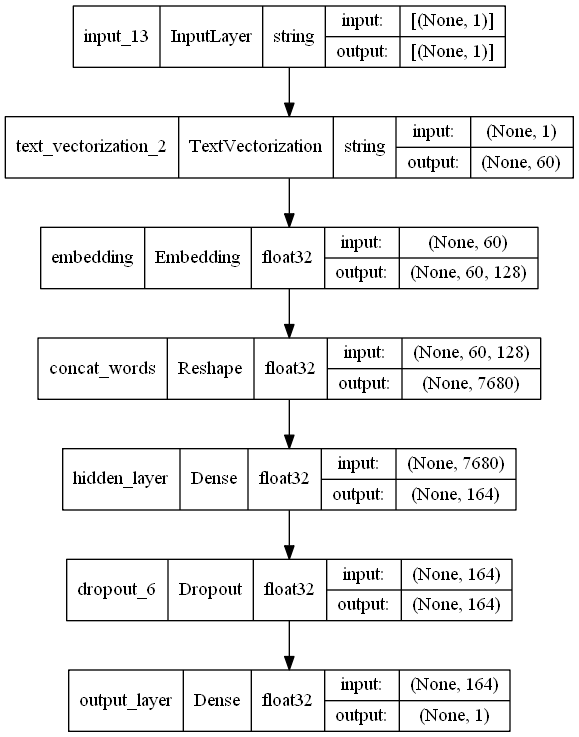

time: 266 ms (started: 2022-05-14 22:19:20 +03:00)


In [176]:
tf.keras.utils.plot_model(conc_model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [177]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    #patience=2,
    patience=5,
    verbose=0,
    restore_best_weights=True
)

history = conc_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 70s 92ms/step - loss: 24.8295 - mean_squared_error: 1081.4232 - mean_absolute_error: 24.8295 - val_loss: 2.6591 - val_mean_squared_error: 10.9267 - val_mean_absolute_error: 2.6591
Epoch 2/20
750/750 [==============================] - 68s 90ms/step - loss: 8.7179 - mean_squared_error: 118.6083 - mean_absolute_error: 8.7179 - val_loss: 2.6928 - val_mean_squared_error: 11.3353 - val_mean_absolute_error: 2.6928
Epoch 3/20
750/750 [==============================] - 68s 90ms/step - loss: 8.6785 - mean_squared_error: 117.8671 - mean_absolute_error: 8.6785 - val_loss: 2.6221 - val_mean_squared_error: 10.5396 - val_mean_absolute_error: 2.6221
Epoch 4/20
750/750 [==============================] - 70s 93ms/step - loss: 8.6445 - mean_squared_error: 117.1284 - mean_absolute_error: 8.6445 - val_loss: 2.6699 - val_mean_squared_error: 11.0530 - val_mean_absolute_error: 2.6699
Epoch 5/20
750/750 [==============================] - 73s 97ms/step - los

In [178]:
test_data['conc_prediction'] = conc_model.predict(test_data[text_col])

time: 8.66 s (started: 2022-05-14 22:28:43 +03:00)


In [179]:
calc_prediction_quality(test_data, 'conc_prediction', target_col)

MSE    10.539561
MAE     2.622139
R2     -0.104340
dtype: float64

time: 16 ms (started: 2022-05-14 22:28:52 +03:00)


In [180]:
test_data.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,dnn_prediction,conc_prediction
25,US,"Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied rasp...",King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard Pinot Noir (Sonoma Coast),Pinot Noir,Castello di Amorosa,91.146004,87.460396


time: 16 ms (started: 2022-05-14 22:28:52 +03:00)


## Finding Optimized Params for Embeddings

In [210]:
from src.embeddings import build_sequential
emb_lst = [16,32,64]
dens_nn_lst = [32, 164, 820]
dropout_lst = [0.2, 0.7]
act_fn_lst = ['relu', 'tanh']
batch_sz_lst = [32, 64, 128]

time: 0 ns (started: 2022-05-15 00:22:42 +03:00)


#did not complete loop but best for now:
![best_for_now](best_for_now.JPG)

In [221]:
optimize = False #change to True if wish to run optimization
if optimize == True:
    #loop parameters
    epochs_n=2
    #how to meaure time for each iteration???
    import time
    runs_num = len(emb_lst)*len(dens_nn_lst)*len(dropout_lst)*len(act_fn_lst)*len(batch_sz_lst)
    run = 1
    rdata_lst = [] #results data - list of dict
    #loop over parameters
    for embedding_dim in emb_lst:
        for dens_nn in dens_nn_lst:
            for dropout_n in dropout_lst:
                for activ_fn in act_fn_lst:
                    for batch_size in batch_sz_lst:
                        str_t = time.time()  #start time of model
                        print(f'starting run {run}...    from {runs_num} runs')
                        temp_model = build_sequential(vectorize_layer, vocab_size, embedding_dim, sequence_length, 
                                                      dens_nn, dropout_n, activ_fn)
                        temp_model.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', 
                                           metrics=['mean_squared_error','mean_absolute_error'])
                        history = temp_model.fit(train_data[text_col], train_data[target_col], epochs=epochs_n, batch_size=batch_size, 
                                                 verbose=0, callbacks=[early_stopping_monitor], 
                                                 validation_data = (test_data[text_col], test_data[target_col]))
                        test_data['emb_prediction'] = temp_model.predict(test_data[text_col])
                        #printing and collecting results data
                        end_t = time.time()   #end time of model
                        elp_t = end_t - str_t #elapsed time of model
                        print(f'elapsed time: {elp_t} seconds')
                        print(f'vocab_size: {vocab_size}, embedding_dim: {embedding_dim}, sequence_length: {sequence_length}')
                        print(f'dens_nn: {dens_nn}, dropout_n: {dropout_n}, activ_fn: {activ_fn}')
                        print(f'batch size: {batch_size}')
                        stats = calc_prediction_quality(test_data, 'emb_prediction', target_col)
                        print(stats)
                        print('-------------------------------------------------------------')
                        iter_dic = {}
                        iter_dic.update({"iteration": run, "vocab_size": vocab_size, "embedding_dim": embedding_dim,
                                        "sequence_length": sequence_length, "dens_nn": dens_nn, "dropout_n": dropout_n,
                                        "activ_fn": activ_fn, "batch_size": batch_size, "mse": stats.loc['MSE'], "mae": stats.loc['MAE'],
                                        "r2": stats.loc['R2'], "elp_t": elp_t})
                        rdata_lst.append(iter_dic)
                        run = run + 1

starting run 1...    from 108 runs
elapsed time: 86.1405975818634 seconds
vocab_size: 20000, embedding_dim: 16, sequence_length: 60
dens_nn: 32, dropout_n: 0.2, activ_fn: relu
batch size: 32
MSE    9.730953
MAE    2.481148
R2    -0.019614
dtype: float64
-------------------------------------------------------------
starting run 2...    from 108 runs
elapsed time: 67.41285514831543 seconds
vocab_size: 20000, embedding_dim: 16, sequence_length: 60
dens_nn: 32, dropout_n: 0.2, activ_fn: relu
batch size: 64
MSE    6.249448
MAE    1.862569
R2     0.345180
dtype: float64
-------------------------------------------------------------
starting run 3...    from 108 runs
elapsed time: 55.39038920402527 seconds
vocab_size: 20000, embedding_dim: 16, sequence_length: 60
dens_nn: 32, dropout_n: 0.2, activ_fn: relu
batch size: 128
MSE    10.239693
MAE     2.410395
R2     -0.072920
dtype: float64
-------------------------------------------------------------
starting run 4...    from 108 runs
elapsed tim

In [222]:
#results of optimization parameters into df
optim_df = pd.DataFrame(rdata_lst)

time: 0 ns (started: 2022-05-15 21:24:34 +03:00)


In [227]:
optim_df.to_pickle("data/optim_df.pkl")
optim_df.head(1)

,iteration,vocab_size,embedding_dim,sequence_length,dens_nn,dropout_n,activ_fn,batch_size,mse,mae,r2,elp_t
0,1,20000,16,60,32,0.2,relu,32,9.730953,2.481148,-0.019614,86.140598


time: 16 ms (started: 2022-05-15 21:32:01 +03:00)


In [229]:
optim_df.nsmallest(10, 'mae', keep='all')

,iteration,vocab_size,embedding_dim,sequence_length,dens_nn,dropout_n,activ_fn,batch_size,mse,mae,r2,elp_t
27,28,20000,16,60,820,0.2,tanh,32,3.009158,1.363025,0.684699,138.986166
28,29,20000,16,60,820,0.2,tanh,64,3.003183,1.366302,0.685325,98.926738
63,64,20000,32,60,820,0.2,tanh,32,3.040487,1.372700,0.681416,191.565723
64,65,20000,32,60,820,0.2,tanh,64,3.066802,1.380165,0.678659,124.203110
29,30,20000,16,60,820,0.2,tanh,128,3.087359,1.383396,0.676505,75.026769
62,63,20000,32,60,820,0.2,relu,128,3.725028,1.478728,0.609690,99.164105
24,25,20000,16,60,820,0.2,relu,32,3.710740,1.479191,0.611187,139.953727
97,98,20000,64,60,820,0.2,relu,64,3.752114,1.485213,0.606852,188.105896
99,100,20000,64,60,820,0.2,tanh,32,3.555958,1.488321,0.627405,398.967297
61,62,20000,32,60,820,0.2,relu,64,3.835034,1.504897,0.598163,130.368939


time: 0 ns (started: 2022-05-15 21:33:38 +03:00)


In [230]:
optim_df.nsmallest(10, 'mse', keep='all')

,iteration,vocab_size,embedding_dim,sequence_length,dens_nn,dropout_n,activ_fn,batch_size,mse,mae,r2,elp_t
28,29,20000,16,60,820,0.2,tanh,64,3.003183,1.366302,0.685325,98.926738
27,28,20000,16,60,820,0.2,tanh,32,3.009158,1.363025,0.684699,138.986166
63,64,20000,32,60,820,0.2,tanh,32,3.040487,1.372700,0.681416,191.565723
64,65,20000,32,60,820,0.2,tanh,64,3.066802,1.380165,0.678659,124.203110
29,30,20000,16,60,820,0.2,tanh,128,3.087359,1.383396,0.676505,75.026769
99,100,20000,64,60,820,0.2,tanh,32,3.555958,1.488321,0.627405,398.967297
33,34,20000,16,60,820,0.7,tanh,32,3.626550,1.509326,0.620008,136.874556
24,25,20000,16,60,820,0.2,relu,32,3.710740,1.479191,0.611187,139.953727
62,63,20000,32,60,820,0.2,relu,128,3.725028,1.478728,0.609690,99.164105
97,98,20000,64,60,820,0.2,relu,64,3.752114,1.485213,0.606852,188.105896


time: 0 ns (started: 2022-05-15 21:35:38 +03:00)


#### Running (fully connected, concat) with optimized parameters

In [231]:
#optimized params chosen
embedding_dim = 16
dens_nn = 820 
dropout_n = 0.2 
activ_fn = 'tanh'
batch_size  = 64
#
epochs_n = 50

####
str_t = time.time()  #start time of model
temp_model = build_sequential(vectorize_layer, vocab_size, embedding_dim, sequence_length, 
                              dens_nn, dropout_n, activ_fn)
temp_model.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', 
                   metrics=['mean_squared_error','mean_absolute_error'])
history = temp_model.fit(train_data[text_col], train_data[target_col], epochs=epochs_n, batch_size=batch_size, 
                         verbose=1, callbacks=[early_stopping_monitor], 
                         validation_data = (test_data[text_col], test_data[target_col]))
test_data['emb_prediction'] = temp_model.predict(test_data[text_col])
#printing and collecting results data
end_t = time.time()   #end time of model
elp_t = end_t - str_t #elapsed time of model
print(f'elapsed time: {elp_t} seconds')
print(f'vocab_size: {vocab_size}, embedding_dim: {embedding_dim}, sequence_length: {sequence_length}')
print(f'dens_nn: {dens_nn}, dropout_n: {dropout_n}, activ_fn: {activ_fn}')
print(f'batch size: {batch_size}')
stats = calc_prediction_quality(test_data, 'emb_prediction', target_col)
print(stats)
print('-------------------------------------------------------------')

starting run 109...    from 108 runs
Epoch 1/50
1500/1500 [==============================] - 51s 33ms/step - loss: 4.3726 - mean_squared_error: 126.4861 - mean_absolute_error: 4.3726 - val_loss: 1.5024 - val_mean_squared_error: 3.6341 - val_mean_absolute_error: 1.5024
Epoch 2/50
1500/1500 [==============================] - 57s 38ms/step - loss: 1.8995 - mean_squared_error: 5.7113 - mean_absolute_error: 1.8995 - val_loss: 1.4267 - val_mean_squared_error: 3.2363 - val_mean_absolute_error: 1.4267
Epoch 3/50
1500/1500 [==============================] - 58s 38ms/step - loss: 1.8337 - mean_squared_error: 5.3116 - mean_absolute_error: 1.8337 - val_loss: 1.3549 - val_mean_squared_error: 2.9609 - val_mean_absolute_error: 1.3549
Epoch 4/50
1500/1500 [==============================] - 54s 36ms/step - loss: 1.7878 - mean_squared_error: 5.0814 - mean_absolute_error: 1.7878 - val_loss: 1.4361 - val_mean_squared_error: 3.2646 - val_mean_absolute_error: 1.4361
Epoch 5/50
1500/1500 [===================

In [ ]:
#calculate model results
#ran calc_prediction_quality above to 'stats'
all_compared = all_compared.append(stats.to_frame(name='opt_concat_embd').transpose())
all_compared

In [272]:
#save results to file
all_compared.to_csv('data/all_models_compared.csv', index=False)
all_compared.to_pickle("data/all_models_compared.pkl")

In [273]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using bow_linear_reg  =  2.824
min MAE using bow_linear_reg  =  1.322
max R2 using bow_linear_reg  =  0.698


## LSTM

In [263]:
#how to use sequential without a fixed input?

time: 78 ms (started: 2022-05-20 13:51:44 +03:00)


In [1]:
#create early stopping callback
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    restore_best_weights=True
)

NameError: name 'EarlyStopping' is not defined

In [264]:
vocab_size = 32000
sequence_length = 71 #max review

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer2 = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

vectorize_layer2.adapt(train_data['description'])

time: 8.19 s (started: 2022-05-20 13:51:47 +03:00)


In [270]:
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam

#optimized params chosen
embedding_dim = 8
dens_nn = 32 
dropout_n = 0.2 
activ_fn = 'tanh'
batch_size  = 64
#
epochs_n = 50

# model = Sequential()

# model.add(Embedding(vocab_size, embedding_dim, input_length= sequence_length, name="embedding"))
# model.add(LSTM(units=dens_nn, activation=activ_fn, name='hidden_layer'))
# model.add(Dropout(dropout_n))
# model.add(Dense(1, name = 'output_layer'))

model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer2,
        Embedding(vocab_size, embedding_dim, input_length= sequence_length, name="embedding"),
        LSTM(units=dens_nn, activation=activ_fn, name='hidden_layer'),
        Dropout(dropout_n),
        Dense(1, name = 'output_layer')
    ])

time: 344 ms (started: 2022-05-20 13:54:12 +03:00)


In [271]:
optimizer = Adam(learning_rate=3e-4)
model.compile(loss='mse', optimizer=optimizer)

time: 0 ns (started: 2022-05-20 13:54:13 +03:00)


In [272]:
model.summary()

Model: "sequential_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 71)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 71, 8)             256000    
                                                                 
 hidden_layer (LSTM)         (None, 32)                5248      
                                                                 
 dropout_194 (Dropout)       (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 261,281
Trainable params: 261,281
Non-trainable params: 0
______________________________________________

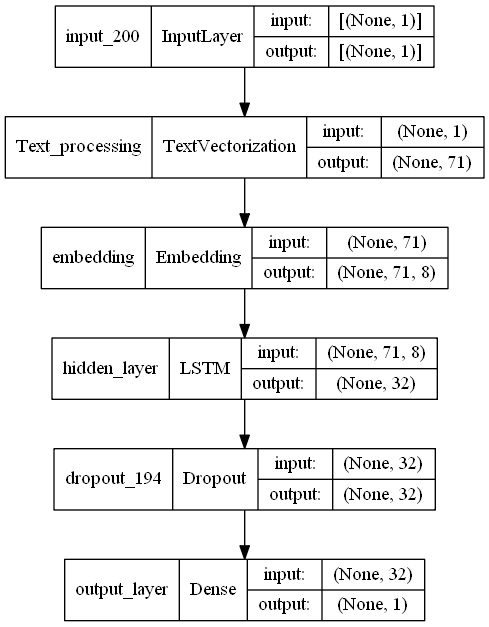

time: 390 ms (started: 2022-05-20 13:54:19 +03:00)


In [273]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [275]:
history = model.fit(train_data[text_col], train_data[target_col], epochs=epochs_n, batch_size=batch_size, 
                         verbose=1, #callbacks=[early_stopping_monitor], 
                         validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/50
1500/1500 [==============================] - 124s 82ms/step - loss: 1991.9896 - val_loss: 1457.5974
Epoch 2/50
1500/1500 [==============================] - 128s 86ms/step - loss: 1076.9417 - val_loss: 707.1876
Epoch 3/50
1500/1500 [==============================] - 125s 84ms/step - loss: 495.9236 - val_loss: 263.6570
Epoch 4/50
1500/1500 [==============================] - 128s 85ms/step - loss: 191.2543 - val_loss: 65.1049
Epoch 5/50
1500/1500 [==============================] - 144s 96ms/step - loss: 84.4770 - val_loss: 14.4644
Epoch 6/50
1500/1500 [==============================] - 129s 86ms/step - loss: 67.3484 - val_loss: 10.0854
Epoch 7/50
1500/1500 [==============================] - 141s 94ms/step - loss: 66.5395 - val_loss: 9.8936
Epoch 8/50
1500/1500 [==============================] - 123s 82ms/step - loss: 64.7489 - val_loss: 6.1164
Epoch 9/50
1500/1500 [==============================] - 117s 78ms/step - loss: 62.3048 - val_loss: 6.4216
Epoch 10/50
1500/1500 [=======

KeyboardInterrupt: 

time: 57min 51s (started: 2022-05-20 13:59:16 +03:00)


In [ ]:
test_data['lstm_prediction'] = temp_model.predict(test_data[text_col])

## Comparing Results

In [181]:
unpickled_df = pd.read_pickle("data/all_models_compared.pkl")
unpickled_df

,MSE,MAE,R2
baseline_1,9.339065,2.500378,-0.000018
baseline_2,8.850588,2.427211,0.052288
baseline_3,8.304271,2.335421,0.110787
regression_by_xgb,6.407902,1.913172,0.313848
ridge linear reg,7.969064,2.242928,0.146681
knn,6.191335,1.940548,0.337038
bow_linear_reg,2.823552,1.322425,0.697657
united_bow_enc_l_reg,3.351487,1.433847,0.641126
neuron network,7.569422,2.216089,0.189474
neuron network scaled,5.633598,1.882234,0.396760


time: 16 ms (started: 2022-05-14 22:28:53 +03:00)


In [182]:
print('min MSE using', unpickled_df.MSE.idxmin(), " = ", f'{unpickled_df.MSE.min():.3f}')
print('min MAE using', unpickled_df.MAE.idxmin(), " = ", f'{unpickled_df.MAE.min():.3f}')
print('max R2 using', unpickled_df.R2.idxmax(), " = ", f'{unpickled_df.R2.max():.3f}')

min MSE using bow_linear_reg  =  2.824
min MAE using bow_linear_reg  =  1.322
max R2 using bow_linear_reg  =  0.698
time: 0 ns (started: 2022-05-14 22:28:53 +03:00)


## Scribble (ignore)

In [183]:
pd.set_option('display.max_colwidth',200)

time: 0 ns (started: 2022-05-14 22:28:53 +03:00)


In [184]:
wines[['description', 'points']].sample(5)

,description,points
43725,"Aromas of fines herbes, chocolate and licorice follow through onto the medium- to full-bodied palate, which displays balanced acids and finessed tannins.",88
64136,"Rich and aromatic, with a full blast of fragrant toasty oak and plenty of tropical fruit. The apple, mango and pear fruit that coats your mouth is round and ripe but not too thick or grabby. And t...",90
54445,"Freshness dominates this bright, fruity wine. There are apple, pear and apricot flavors with just the lightest touch of vanilla. At the end, the wine shows a great tangy character, full of lemon a...",87
22862,"Winemaker Virginia Willcock's latest effort shows that top-flight Margaret River Chardonnay doesn't have to cost three figures. This is fine stuff, a bit funky at first, but opening up in the glas...",93
114464,"The inclusion of 11% Aligoté, which was sourced from a block planted in 1979, makes this Chardonnay unique. The Aligoté seems to thicken the core fruit, and it adds flesh and rind-like flavor, alo...",90


time: 15 ms (started: 2022-05-14 22:28:53 +03:00)


In [185]:
wines.description.loc[wines.points == 80]

344       Aromas of pumpkin, squash and corn chips are stale and not inviting. There's an acceptable mouthfeel to this weird, unbalanced Chardonnay along with flavors of spiced squash, mealy apple and sauté...
3640                                                                          Aromas of strawberry sherbet are followed by sweet candy-shop flavors on the palate. Chill it thoroughly before drinking. Screwcap.
3641              Fluffy, sweet aromas of peach, pear and vanilla are as good as it gets. Tastes of powdered sugar and the most forced oak you can imagine. Not at all surprising that it's resiny on the finish.
4556                                                     There's a thorny, almost raw quality of fruit here that is backed by a touch of dill weed and black tar. It feels tart and slightly bitter on the close.
4557      With dusty, candied aromas, the bouquet on this semisweet Cava is scattered all over the map. In the mouth, it's inoffensive, however the wine's candi

time: 0 ns (started: 2022-05-14 22:28:54 +03:00)


(array([ 230.,  921., 2505., 3329., 2583., 2363., 1473.,  610.,  123.,
          29.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 10 artists>)

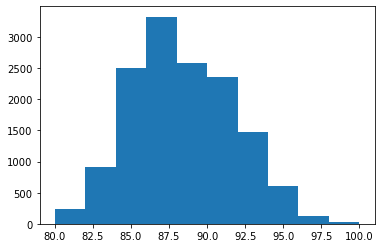

time: 250 ms (started: 2022-05-14 22:28:54 +03:00)


In [186]:
import matplotlib.pyplot as plt
plt.hist(wines.points[wines.description.str.contains('sweet')])

In [187]:
wines.points[wines.description.str.contains('weak|Weak')].describe()

count    139.000000
mean      84.748201
std        3.334261
min       80.000000
25%       82.000000
50%       84.000000
75%       87.000000
max       94.000000
Name: points, dtype: float64

time: 266 ms (started: 2022-05-14 22:28:54 +03:00)


In [188]:
wines.points.describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

time: 15 ms (started: 2022-05-14 22:28:55 +03:00)


In [189]:
weak_words = ['weak', 'stale', 'vegetable', 'sauerkraut', 'buttery', 'funky', 'iron','overtly', 'overly', 'sour']
total_mean = wines.points.mean()
print(f'total mean= {total_mean:.3f}')
print("------------------------------------------------")
for i in weak_words:
    i_mean = wines.points[wines.description.str.contains(i)].mean()
    print(f'{i}   mean= {i_mean:.3f} diff from total= {(total_mean - i_mean):.3f}')

total mean= 88.442
------------------------------------------------
weak   mean= 84.881 diff from total= 3.562
stale   mean= 83.222 diff from total= 5.220
vegetable   mean= 85.856 diff from total= 2.587
sauerkraut   mean= 82.783 diff from total= 5.660
buttery   mean= 88.130 diff from total= 0.312
funky   mean= 86.705 diff from total= 1.737
iron   mean= 90.520 diff from total= -2.078
overtly   mean= 86.677 diff from total= 1.765
overly   mean= 87.698 diff from total= 0.744
sour   mean= 87.840 diff from total= 0.602
time: 828 ms (started: 2022-05-14 22:28:55 +03:00)


(array([ 1086.,  4777., 15292., 26805., 26438., 24452., 15121.,  5139.,
          749.,   129.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 10 artists>)

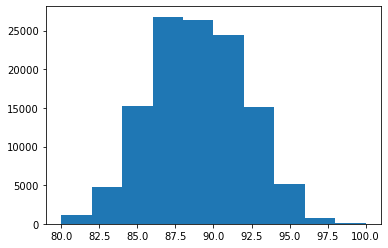

time: 141 ms (started: 2022-05-14 22:28:56 +03:00)


In [190]:
plt.hist(wines.points)

## NLP BoW and Encoded Wines Features